In [1]:
import pandas as pd
from freesurfer_stats import CorticalParcellationStats
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting

/opt/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")

## PLS ANALYSIS

In [3]:
all_volumes_file = 'data/all_volumes.csv'
all_volumes = pd.read_csv(all_volumes_file)
all_volumes.drop(columns=all_volumes.columns[0], axis=1, inplace=True)
#all_volumes.columns.to_list()

In [4]:
# Selección de estructuras, no se inlcluye el 5to ventrículo
columns = list(range(0,15)) + list(range(21,54)) + list(range(61,467))
#columns = list(range(0,4)) + list(range(21,54)) + list(range(61,467))
selected_values = all_volumes.iloc[:,columns]
#list(selected_values.columns)
selected_values

subject grupo    project  Brain Segmentation Volume  \
0    CTRL028   CTR  controles                  1497849.0   
1    CTRL020   CTR  controles                   933391.0   
2    CTRL035   CTR  controles                  1255844.0   
3    CTRL032   CTR  controles                  1071906.0   
4    CTRL027   CTR  controles                  1026530.0   
..       ...   ...        ...                        ...   
269  EQFP055   EQF    prisma3                   991325.0   
270  TABP012   TAB    prisma3                  1065783.0   
271  TABP007   TAB    prisma3                  1000844.0   
272  TABP104   TAB    prisma3                  1023724.0   
273  EQFP039   EQF    prisma3                  1105815.0   

     Brain Segmentation Volume Without Ventricles  \
0                                       1469945.0   
1                                        911481.0   
2                                       1243560.0   
3                                       1051838.0   
4                                       1015857.0   
..                                            ...   
269                                      977632.0   
270                                     1029263.0   
271                                      974180.0   
272                                     1002543.0   
273                                     1083404.0   

     Volume of ventricles and choroid plexus  \
0                                    23662.0   
1                                    18759.0   
2                                     9261.0   
3                                    17281.0   
4                                     8536.0   
..                                       ...   
269                                  10743.0   
270                                  32002.0   
271                                  23334.0   
272                                  17867.0   
273                                  18137.0   

     Left hemisphere cortical gray matter volume  \
0                                      324114.47   
1                                      201383.48   
2                                      267640.20   
3                                      228594.89   
4                                      205196.94   
..                                           ...   
269                                    215687.70   
270                                    222385.12   
271                                    195058.62   
272                                    221062.58   
273                                    217193.77   

     Right hemisphere cortical gray matter volume  \
0                                       321189.00   
1                                       202423.16   
2                                       268375.88   
3                                       228889.97   
4                                       207710.86   
..                                            ...   
269                                     217681.12   
270                                     221814.16   
271                                     197406.92   
272                                     220406.72   
273                                     218888.11   

     Total cortical gray matter volume  \
0                            645303.50   
1                            403806.62   
2                            536016.06   
3                            457484.84   
4                            412907.78   
..                                 ...   
269                          433368.80   
270                          444199.28   
271                          392465.53   
272                          441469.28   
273                          436081.88   

     Left hemisphere cerebral white matter volume  ...  \
0                                        300938.0  ...   
1                                        177091.0  ...   
2                                        254156.0  ...   
3                                        205670.5  ...   
4            

## NORMALIZATION BY ETIV

In [5]:
selected_values.iloc[:,3:] = selected_values.iloc[:,3:].div(selected_values["Estimated Total Intracranial Volume"], axis=0)
selected_values

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_97750/996222792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_values.iloc[:,3:] = selected_values.iloc[:,3:].div(selected_values["Estimated Total Intracranial Volume"], axis=0)


subject grupo    project  Brain Segmentation Volume  \
0    CTRL028   CTR  controles                   0.829100   
1    CTRL020   CTR  controles                   0.798626   
2    CTRL035   CTR  controles                   0.860477   
3    CTRL032   CTR  controles                   0.806800   
4    CTRL027   CTR  controles                   0.847668   
..       ...   ...        ...                        ...   
269  EQFP055   EQF    prisma3                   0.800666   
270  TABP012   TAB    prisma3                   0.803860   
271  TABP007   TAB    prisma3                   0.741454   
272  TABP104   TAB    prisma3                   0.779844   
273  EQFP039   EQF    prisma3                   0.772165   

     Brain Segmentation Volume Without Ventricles  \
0                                        0.813654   
1                                        0.779879   
2                                        0.852060   
3                                        0.791695   
4                                        0.838854   
..                                            ...   
269                                      0.789607   
270                                      0.776315   
271                                      0.721701   
272                                      0.763709   
273                                      0.756516   

     Volume of ventricles and choroid plexus  \
0                                   0.013098   
1                                   0.016051   
2                                   0.006345   
3                                   0.013007   
4                                   0.007049   
..                                       ...   
269                                 0.008677   
270                                 0.024137   
271                                 0.017287   
272                                 0.013611   
273                                 0.012665   

     Left hemisphere cortical gray matter volume  \
0                                       0.179406   
1                                       0.172307   
2                                       0.183381   
3                                       0.172058   
4                                       0.169443   
..                                           ...   
269                                     0.174205   
270                                     0.167733   
271                                     0.144505   
272                                     0.168399   
273                                     0.151661   

     Right hemisphere cortical gray matter volume  \
0                                        0.177787   
1                                        0.173197   
2                                        0.183885   
3                                        0.172280   
4                                        0.171519   
..                                            ...   
269                                      0.175815   
270                                      0.167302   
271                                      0.146245   
272                                      0.167900   
273                                      0.152845   

     Total cortical gray matter volume  \
0                             0.357193   
1                             0.345504   
2                             0.367266   
3                             0.344339   
4                             0.340963   
..                                 ...   
269                           0.350020   
270                           0.335035   
271                           0.290750   
272                           0.336299   
273                           0.304506   

     Left hemisphere cerebral white matter volume  ...  \
0                                        0.166577  ...   
1                                        0.151522  ...   
2                                        0.174142  ...   
3                                        0.154804  ...   
4            

In [6]:
all_data = selected_values
#all_data[all_data['subject']=='TABP079']

In [7]:
# Remover columna de ETIV
all_data = all_data.drop(['Estimated Total Intracranial Volume'],axis=1)
#all_data

## Clinical data

In [8]:
clinical_file = 'data/clinical_data_prisma_VF.xlsx'
clinical_data = pd.read_excel(clinical_file,'master')
clinical_data

Group id_PRISMA  time  treatment  edad  gen   esc   dx  psc    id_RM  \
0     TAB    PRT002     1        2.0  46.0  0.0  17.0  1.0  0.0  TABP001   
1     TAB    PRT002     2        2.0  48.0  NaN  17.0  1.0  0.0  TABP001   
2     TAB    PRT002     3        2.0  52.0  NaN  17.0  1.0  0.0  TABP001   
3     TAB    PRT005     1        1.0  35.0  0.0   6.0  1.0  0.0  TABP003   
4     TAB    PRT005     2        1.0  37.0  NaN   6.0  1.0  0.0  TABP003   
..    ...       ...   ...        ...   ...  ...   ...  ...  ...      ...   
503   CTR       NaN     3        0.0  19.0  0.0  11.0  0.0  0.0  CTRL036   
504   CTR       NaN     3        0.0  31.0  0.0  16.0  0.0  0.0  CTRL037   
505   CTR       NaN     3        0.0  26.0  1.0  16.0  0.0  0.0  CTRL038   
506   CTR       NaN     3        0.0  23.0  1.0  15.0  0.0  0.0  CTRL039   
507   CTR       NaN     3        0.0  55.0  0.0  16.0  0.0  0.0  CTRL040   

     dur_enf  hsp  num_inte  ep_dep  ep_man  Gravedad  
0        7.0  0.0       NaN     3.0     2.0  0.714286  
1        9.0  0.0       NaN     0.0     0.0  0.000000  
2       13.0  0.0       NaN     0.0     6.0  0.461538  
3       10.0  2.0       NaN     1.0     1.0  0.400000  
4       12.0  0.0       NaN     0.0     0.0  0.000000  
..       ...  ...       ...     ...     ...       ...  
503      NaN  NaN       NaN     NaN     NaN  0.000000  
504      NaN  NaN       NaN     NaN     NaN  0.000000  
505      NaN  NaN       NaN     NaN     NaN  0.000000  
506      NaN  NaN       NaN     NaN     NaN  0.000000  
507      NaN  NaN       NaN     NaN     NaN  0.000000  

[508 rows x 16 columns]

In [9]:
clinical_data = clinical_data.iloc[:, [9,0,2,3,4,5,6,7,8,15]]
clinical_data.rename(columns = {'id_RM':'subject'}, inplace = True)
#clinical_data

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_97750/1443194788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data.rename(columns = {'id_RM':'subject'}, inplace = True)


In [10]:
clinical_data

subject Group  time  treatment  edad  gen   esc   dx  psc  Gravedad
0    TABP001   TAB     1        2.0  46.0  0.0  17.0  1.0  0.0  0.714286
1    TABP001   TAB     2        2.0  48.0  NaN  17.0  1.0  0.0  0.000000
2    TABP001   TAB     3        2.0  52.0  NaN  17.0  1.0  0.0  0.461538
3    TABP003   TAB     1        1.0  35.0  0.0   6.0  1.0  0.0  0.400000
4    TABP003   TAB     2        1.0  37.0  NaN   6.0  1.0  0.0  0.000000
..       ...   ...   ...        ...   ...  ...   ...  ...  ...       ...
503  CTRL036   CTR     3        0.0  19.0  0.0  11.0  0.0  0.0  0.000000
504  CTRL037   CTR     3        0.0  31.0  0.0  16.0  0.0  0.0  0.000000
505  CTRL038   CTR     3        0.0  26.0  1.0  16.0  0.0  0.0  0.000000
506  CTRL039   CTR     3        0.0  23.0  1.0  15.0  0.0  0.0  0.000000
507  CTRL040   CTR     3        0.0  55.0  0.0  16.0  0.0  0.0  0.000000

[508 rows x 10 columns]

## Edit file

In [11]:
pd.set_option('display.max_rows', None)

#add same treatment in all times
l=['Group','time','edad','gen','esc','dx','psc', 'Gravedad'] # column different from each row
clinical_data_f = pd.concat([clinical_data.drop(l,1).groupby('subject').transform('first'),clinical_data[l],clinical_data[['subject']]],axis=1).reindex(columns=clinical_data.columns)

clinical_data_f['project'] = 'prisma'+ clinical_data_f.time.astype(str)

clinical_data_f.loc[clinical_data_f.Group == 'CTR', 'project'] = "controles"
# Agregar condición
#clinical_data_f['c_group'] = clinical_data_f['Group'] + '-' + clinical_data_f['project'] +'-' +'treatment' + clinical_data_f['treatment'].astype(str)
clinical_data_f['c_group'] = clinical_data_f['Group'] + '-' + clinical_data_f['project'] 

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_97750/3466945000.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  clinical_data_f = pd.concat([clinical_data.drop(l,1).groupby('subject').transform('first'),clinical_data[l],clinical_data[['subject']]],axis=1).reindex(columns=clinical_data.columns)


In [12]:
clinical_data_f

subject Group  time  treatment  edad  gen   esc   dx  psc  Gravedad  \
0    TABP001   TAB     1        2.0  46.0  0.0  17.0  1.0  0.0  0.714286   
1    TABP001   TAB     2        2.0  48.0  NaN  17.0  1.0  0.0  0.000000   
2    TABP001   TAB     3        2.0  52.0  NaN  17.0  1.0  0.0  0.461538   
3    TABP003   TAB     1        1.0  35.0  0.0   6.0  1.0  0.0  0.400000   
4    TABP003   TAB     2        1.0  37.0  NaN   6.0  1.0  0.0  0.000000   
5    TABP003   TAB     3        1.0   NaN  NaN   NaN  NaN  NaN       NaN   
6    TABP004   TAB     1        2.0  55.0  0.0  15.0  1.0  1.0  0.142857   
7    TABP004   TAB     2        2.0  56.0  NaN   NaN  1.0  0.0  0.000000   
8    TABP004   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
9    TABP012   TAB     1        2.0  50.0  0.0   6.0  1.0  1.0  0.200000   
10   TABP012   TAB     2        2.0  52.0  NaN   6.0  1.0  0.0  0.000000   
11   TABP012   TAB     3        2.0  56.0  NaN   6.0  1.0  0.0  0.064516   
12   TABP060   TAB     1        1.0  57.0  1.0  11.0  1.0  0.0  1.379310   
13   TABP060   TAB     2        1.0  58.0  NaN   NaN  1.0  0.0  0.000000   
14   TABP060   TAB     3        1.0  63.0  NaN  11.0  1.0  0.0  0.000000   
15   TABP057   TAB     1        2.0  28.0  1.0  13.0  1.0  1.0       NaN   
16   TABP057   TAB     2        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
17   TABP057   TAB     3        2.0  34.0  NaN  13.0  1.0  0.0  0.571429   
18   TABP013   TAB     1        2.0  57.0  0.0  11.0  1.0  1.0  0.769231   
19   TABP013   TAB     2        2.0  58.0  NaN   NaN  1.0  0.0  0.000000   
20   TABP013   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
21   TABP009   TAB     1        2.0  52.0  0.0   8.0  1.0  0.0  0.172414   
22   TABP009   TAB     2        2.0  53.0  NaN   NaN  1.0  0.0  0.000000   
23   TABP009   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
24   TABP010   TAB     1        2.0  52.0  0.0   5.0  1.0  0.0  1.000000   
25   TABP010   TAB     2        2.0  53.0  NaN   NaN  1.0  0.0  0.200000   
26   TABP010   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
27   TABP017   TAB     1        1.0  37.0  0.0  15.0  1.0  1.0  0.391304   
28   TABP017   TAB     2        1.0  39.0  NaN   NaN  1.0  0.0  0.040000   
29   TABP017   TAB     3        1.0  44.0  NaN  15.0  1.0  1.0  0.133333   
30   TABP021   TAB     1        2.0  43.0  0.0  12.0  1.0  1.0  0.714286   
31   TABP021   TAB     2        2.0  45.0  NaN   NaN  1.0  0.0  0.000000   
32   TABP021   TAB     3        2.0  49.0  NaN  12.0  1.0  0.0  0.307692   
33   TABP030   TAB     1        2.0  55.0  1.0   2.0  1.0  1.0  0.236842   
34   TABP030   TAB     2        2.0  57.0  NaN   NaN  1.0  1.0  0.100000   
35   TABP030   TAB     3        2.0  61.0  NaN   2.0  1.0  0.0  0.000000   
36   TABP074   TAB     1        2.0  53.0  1.0  17.0  1.0  0.0  0.666667   
37   TABP074   TAB     2        2.0  54.0  NaN   NaN  1.0  0.0  0.000000   
38   TABP074   TAB     3        2.0  58.0  NaN  17.0  1.0  0.0  0.000000   
39   TABP023   TAB     1        2.0  37.0  1.0  12.0  1.0  1.0  0.181818   
40   TABP023   TAB     2        2.0  39.0  NaN   NaN  NaN  0.0  0.000000   
41   TABP023   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
42   TABP073   TAB     1        2.0  55.0  0.0   8.0  1.0  1.0  0.388889   
43   TABP073   TAB     2        2.0  56.0  NaN   NaN  NaN  0.0  0.000000   
44   TABP073   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
45   TABP015   TAB     1        1.0  33.0  0.0  11.0  1.0  0.0  1.200000   
46   TABP015   TAB     2        1.0  34.0  NaN   NaN  1.0  0.0  0.181818   
47   TABP015   TAB     3        1.0   NaN  NaN   NaN  NaN  NaN       NaN   
48   TABP029   TAB     1        2.0  46.0  0.0   9.0  1.0  1.0  0.791667   
49   TABP029   TAB     2        2.0  47.0  NaN   NaN  1.0  0.0  0.040000   
50   TABP029   TAB     3        2.0   NaN  NaN   NaN  NaN  NaN       NaN   
51   TABP066   TAB     1        2.0  50.0  0.0  14.0 

## Merge both files

In [13]:
clinical_image_df= pd.merge(all_data, clinical_data_f[['subject','project','c_group','treatment','psc','dx','Gravedad','edad']], how='left', on=['subject', 'project'])

#Remove data for TAB and diagnosis 2
clinical_image_df.drop(clinical_image_df.index[(clinical_image_df.subject.str.contains('TAB'))&(clinical_image_df.dx==2)],inplace=True)

# Remove subject with NAs in volumetric nan
#clinical_image_df.drop(clinical_image_df.index[clinical_image_df.subject=="TABP079"],inplace=True)


In [14]:
#clinical_image_df

In [15]:
clinical_image_df[clinical_image_df['subject']=='TABP079']
# Remove subject with NAs in volumetric and clinical data
clinical_image_df.drop(clinical_image_df.index[clinical_image_df.subject=="TABP079"],inplace=True)

### NORMALIZE BY GROUP

## Standardscaler

In [16]:
# Standardize features by removing the mean and scaling to unit variance
clinical_image_df_n_CTR= clinical_image_df[clinical_image_df.grupo=='CTR']
clinical_image_df_n_EQF= clinical_image_df[clinical_image_df.grupo=='EQF']
clinical_image_df_n_TAB= clinical_image_df[clinical_image_df.grupo=='TAB']
clinical_image_df_n_CTR.iloc[:,3:-6] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_CTR.iloc[:,3:-6])
clinical_image_df_n_TAB.iloc[:,3:-6] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_TAB.iloc[:,3:-6])
clinical_image_df_n_EQF.iloc[:,3:-6] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_EQF.iloc[:,3:-6])


/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_97750/3410622442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_df_n_CTR.iloc[:,3:-6] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_CTR.iloc[:,3:-6])
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_97750/3410622442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_image_df_n_TAB.iloc[:,3:-6] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_TAB.iloc[:,3:-6])
/var/folders

## Z-score by subject

In [17]:
# Normalización z-score por fila (sujeto)
clinical_image_z = clinical_image_df
clinical_image_z.iloc[:,3:-6] = clinical_image_z.iloc[:,3:-6].apply(zscore, axis=1) 

In [18]:
clinical_image_n = pd.concat([clinical_image_df_n_CTR,clinical_image_df_n_TAB,clinical_image_df_n_EQF])

In [19]:
clinical_image_i = clinical_image_z # Selección normalización por z-score
#clinical_image_i = clinical_image_n # Selección normalización por grupo
clinical_image_EQF = clinical_image_i[clinical_image_i.grupo!='TAB'] # Toma EQF y CTRL
clinical_image_TAB = clinical_image_i[clinical_image_i.grupo!='EQF'] # Toma TAB y CTRL

In [20]:
# Formación datos EQF y TAB --> PSI
clinical_image_i['grupo-p'] = ''
clinical_image_i.loc[clinical_image_i.grupo.str.contains('TAB'), 'grupo-p'] = 'PSI'
clinical_image_i.loc[clinical_image_i.grupo.str.contains('EQF'), 'grupo-p'] = 'PSI'
clinical_image_i.loc[clinical_image_i.grupo.str.contains('CTR'), 'grupo-p'] = 'CTR'
# Modificar condición
#clinical_image_i['c_group'] = clinical_image_i['grupo'] + '-' + clinical_image_i['project'] +'-' +'treatment' + clinical_image_i['treatment'].astype(str)
clinical_image_i['c_group'] = clinical_image_i['grupo-p'] + '-' + clinical_image_i['project'] + '-' + clinical_image_i['grupo']


In [21]:
all_data_sorted_EQF = clinical_image_EQF.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups_EQF = all_data_sorted_EQF.groupby(['c_group']).count()
groups_dict_EQF = count_groups_EQF['subject'].to_dict()

list_len_EQF = list(groups_dict_EQF.values())
groups_EQF = list(groups_dict_EQF.keys())
groups_dict_EQF

{'CTR-controles': 40, 'EQZ-prisma1': 56, 'EQZ-prisma3': 33}

In [22]:
all_data_sorted_EQF = all_data_sorted_EQF.dropna(subset=['c_group'])
#all_data_sorted_EQF

In [23]:
count_groups_EQF = all_data_sorted_EQF.groupby(['c_group']).count()
groups_dict_EQF = count_groups_EQF['subject'].to_dict()

list_len_EQF = list(groups_dict_EQF.values())
groups_EQF = list(groups_dict_EQF.keys())
groups_dict_EQF

{'CTR-controles': 40, 'EQZ-prisma1': 56, 'EQZ-prisma3': 33}

In [24]:
all_data_sorted_TAB = clinical_image_TAB.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups_TAB = all_data_sorted_TAB.groupby(['c_group']).count()
groups_dict_TAB = count_groups_TAB['subject'].to_dict()

list_len_TAB = list(groups_dict_TAB.values())
groups_TAB = list(groups_dict_TAB.keys())
groups_dict_TAB

{'CTR-controles': 40, 'TAB-prisma1': 75, 'TAB-prisma3': 53}

In [25]:
all_data_sorted_TAB = all_data_sorted_TAB.dropna(subset=['c_group'])
#all_data_sorted_TAB

In [26]:
count_groups_TAB = all_data_sorted_TAB.groupby(['c_group']).count()
groups_dict_TAB = count_groups_TAB['subject'].to_dict()

list_len_TAB = list(groups_dict_TAB.values())
groups_TAB = list(groups_dict_TAB.keys())
groups_dict_TAB

{'CTR-controles': 40, 'TAB-prisma1': 75, 'TAB-prisma3': 53}

In [27]:
all_data_sorted_PSI = clinical_image_i.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups_PSI = all_data_sorted_PSI.groupby(['c_group']).count()
groups_dict_PSI = count_groups_PSI['subject'].to_dict()

list_len_PSI = list(groups_dict_PSI.values())
groups_PSI = list(groups_dict_PSI.keys())
groups_dict_PSI

{'CTR-controles-CTR': 40,
 'PSI-prisma1-EQF': 59,
 'PSI-prisma1-TAB': 77,
 'PSI-prisma3-EQF': 33,
 'PSI-prisma3-TAB': 53}

In [28]:
all_data_sorted_PSI = all_data_sorted_PSI.dropna(subset=['c_group'])
count_groups_PSI= all_data_sorted_PSI.groupby(['c_group']).count()
groups_dict_PSI = count_groups_PSI['subject'].to_dict()

list_len_PSI = list(groups_dict_PSI.values())
groups_PSI = list(groups_dict_PSI.keys())
groups_dict_PSI

{'CTR-controles-CTR': 40,
 'PSI-prisma1-EQF': 59,
 'PSI-prisma1-TAB': 77,
 'PSI-prisma3-EQF': 33,
 'PSI-prisma3-TAB': 53}

## PLS WITH CLINICAL GROUPS

In [29]:
X_EQF = all_data_sorted_EQF.iloc[:,3:-6].values
X_TAB = all_data_sorted_TAB.iloc[:,3:-6].values
X_PSI = all_data_sorted_PSI.iloc[:,3:-7].values

In [30]:
random_state=42
pls_EQF = pyls.meancentered_pls(X_EQF, groups=list_len_EQF, seed=42, mean_centering=1, n_proc='max')

Running permutations:   0%|                                                              | 0/5000 | 00:00<?/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you wa

In [31]:
#with open('pls_V_EQF_n.pkl', 'wb') as f:
with open('pls_EQF.pkl', 'wb') as f:
    pickle.dump(pls_EQF, f)

In [32]:
with open("pls_EQF.pkl", "rb") as input_file:
    pls_EQF = pickle.load(input_file)

In [33]:
pls_TAB = pyls.meancentered_pls(X_TAB, groups=list_len_TAB, mean_centering=1, seed=42, n_proc='max')

In [34]:
with open('pls_TAB.pkl', 'wb') as f:
    pickle.dump(pls_TAB, f)

In [35]:
with open("pls_TAB.pkl", "rb") as input_file:
    pls_TAB = pickle.load(input_file)

In [36]:
pls_PSI = pyls.meancentered_pls(X_PSI, groups=list_len_PSI, seed=42, mean_centering=1, n_proc='max')

In [37]:
# Significancia PLS grupos EQF y CTRL, tiempo y tratamiento
pvals_EQF = pls_EQF.permres['pvals']
x_weights_EQF = pls_EQF.bootres.x_weights_normed 
y_weights_EQF = pls_EQF.y_weights
pvals_EQF

array([3.99920016e-04, 8.61027794e-01, 6.99860028e-01])

In [38]:
# Significancia grupos TAB y CTRL, tiempo y tratamiento
pvals_TAB = pls_TAB.permres['pvals']
x_weights_TAB = pls_TAB.bootres.x_weights_normed
y_weights_TAB = pls_TAB.y_weights
pvals_TAB

array([0.01679664, 0.59708058, 0.84603079])

In [39]:
# Significancia grupos EQF+TAB y CTRL, tiempo y tratamiento
pvals_PSI = pls_PSI.permres['pvals']
x_weights_PSI = pls_PSI.bootres.x_weights_normed
y_weights_PSI = pls_PSI.y_weights
pvals_PSI

array([3.99920016e-04, 2.21955609e-01, 5.63887223e-01, 1.00000000e+00,
       4.68506299e-01])

In [40]:
def get_pos(n_col, init=-0.3, inte=0.6):
    pos = []
    for i in range(n_col):
        x = init 
        init = round(x + inte, 1)
        pos.append(x)
    return pos

def errplot(x,y, yerr, **kwargs):
    data = kwargs.pop("data")
    plt.errorbar(x=x,y=data[y],yerr=data[yerr],fmt='none', c= 'k')

In [41]:
# Incluyendo tratamiento
#y_loadings_df_EQF = pd.DataFrame({'1': y_weights_EQF[:,0], '2': y_weights_EQF[:,1], 'condition': groups_EQF,
#                                  'tratamiento': [group.split("-")[2] for group in groups_EQF] , 'time': [group.split("-")[1] for group in groups_EQF]})

#y_loadings_m_EQF = pd.melt(y_loadings_df_EQF,id_vars=['condition','tratamiento','time'],value_name='weight', var_name = 'salvar_id')

# Sin tratamiento
y_loadings_df_EQF = pd.DataFrame({'1': y_weights_EQF[:,0], '2': y_weights_EQF[:,1], 'condition': groups_EQF,
                                  'time': [group.split("-")[1] for group in groups_EQF]})

y_loadings_m_EQF = pd.melt(y_loadings_df_EQF,id_vars=['condition','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_EQF['ci_l'] = np.concatenate([pls_EQF.bootres.contrast_ci[:,0,0], pls_EQF.bootres.contrast_ci[:,1,0]])
y_loadings_m_EQF['ci_u'] = np.concatenate([pls_EQF.bootres.contrast_ci[:,0,1], pls_EQF.bootres.contrast_ci[:,1,1]])

y_loadings_m_EQF['ci_l_p'] = y_loadings_m_EQF['weight'] - y_loadings_m_EQF['ci_l']
y_loadings_m_EQF['ci_u_p'] = y_loadings_m_EQF['weight'] - y_loadings_m_EQF['ci_u']
y_loadings_m_EQF['err'] = (y_loadings_m_EQF['ci_u'] - y_loadings_m_EQF['ci_l'])/2

In [42]:
y_loadings_m_EQF

condition       time salvar_id    weight      ci_l      ci_u    ci_l_p  \
0  CTR-controles  controles         1  0.804704  0.112844  0.245639  0.691860   
1    EQZ-prisma1    prisma1         1 -0.282610 -0.133229  0.006324 -0.149381   
2    EQZ-prisma3    prisma3         1 -0.522094 -0.190864 -0.044963 -0.331231   
3  CTR-controles  controles         2 -0.138266 -0.031651  0.023984 -0.106616   
4    EQZ-prisma1    prisma1         2  0.766028 -0.004946  0.049708  0.770974   
5    EQZ-prisma3    prisma3         2 -0.627761 -0.047099  0.008504 -0.580663   

     ci_u_p       err  
0  0.559065  0.066398  
1 -0.288934  0.069777  
2 -0.477132  0.072950  
3 -0.162251  0.027817  
4  0.716319  0.027327  
5 -0.636265  0.027801

In [43]:
#y_loadings_df_TAB = pd.DataFrame({'1': y_weights_TAB[:,0], '2': y_weights_TAB[:,1], 'condition': groups_TAB,
#                                 'tratamiento': [group.split("-")[2] for group in groups_TAB] , 'time': [group.split("-")[1] for group in groups_TAB]})
#y_loadings_m_TAB = pd.melt(y_loadings_df_TAB,id_vars=['condition','tratamiento','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_df_TAB = pd.DataFrame({'1': y_weights_TAB[:,0], '2': y_weights_TAB[:,1], 'condition': groups_TAB,
                                  'time': [group.split("-")[1] for group in groups_TAB]})
y_loadings_m_TAB = pd.melt(y_loadings_df_TAB,id_vars=['condition','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_TAB['ci_l'] = np.concatenate([pls_TAB.bootres.contrast_ci[:,0,0], pls_TAB.bootres.contrast_ci[:,1,0]])
y_loadings_m_TAB['ci_u'] = np.concatenate([pls_TAB.bootres.contrast_ci[:,0,1], pls_TAB.bootres.contrast_ci[:,1,1]])

y_loadings_m_TAB['ci_l_p'] = y_loadings_m_TAB['weight'] - y_loadings_m_TAB['ci_l']
y_loadings_m_TAB['ci_u_p'] = y_loadings_m_TAB['weight'] - y_loadings_m_TAB['ci_u']
y_loadings_m_TAB['err'] = (y_loadings_m_TAB['ci_u'] - y_loadings_m_TAB['ci_l'])/2

In [44]:
y_loadings_df_PSI = pd.DataFrame({'1': y_weights_PSI[:,0], '2': y_weights_PSI[:,1], 'condition': groups_PSI,
                                  'enfermedad': [group.split("-")[2] for group in groups_PSI] , 'time': [group.split("-")[1] for group in groups_PSI]})

y_loadings_m_PSI = pd.melt(y_loadings_df_PSI,id_vars=['condition','enfermedad','time'],value_name='weight', var_name = 'salvar_id')

#y_loadings_df_PSI = pd.DataFrame({'1': y_weights_PSI[:,0], '2': y_weights_PSI[:,1], 'condition': groups_PSI,
#                                  'time': [group.split("-")[1] for group in groups_PSI]})

#y_loadings_m_PSI = pd.melt(y_loadings_df_PSI,id_vars=['condition','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_PSI['ci_l'] = np.concatenate([pls_PSI.bootres.contrast_ci[:,0,0], pls_PSI.bootres.contrast_ci[:,1,0]])
y_loadings_m_PSI['ci_u'] = np.concatenate([pls_PSI.bootres.contrast_ci[:,0,1], pls_PSI.bootres.contrast_ci[:,1,1]])

y_loadings_m_PSI['ci_l_p'] = y_loadings_m_PSI['weight'] - y_loadings_m_PSI['ci_l']
y_loadings_m_PSI['ci_u_p'] = y_loadings_m_PSI['weight'] - y_loadings_m_PSI['ci_u']
y_loadings_m_PSI['err'] = (y_loadings_m_PSI['ci_u'] - y_loadings_m_PSI['ci_l'])/2

In [45]:
y_loadings_m_PSI

condition enfermedad       time salvar_id    weight      ci_l  \
0  CTR-controles-CTR        CTR  controles         1  0.705705  0.085672   
1    PSI-prisma1-EQF        EQF    prisma1         1 -0.351411 -0.153108   
2    PSI-prisma1-TAB        TAB    prisma1         1  0.066479 -0.039532   
3    PSI-prisma3-EQF        EQF    prisma3         1 -0.588240 -0.213259   
4    PSI-prisma3-TAB        TAB    prisma3         1  0.167468 -0.028742   
5  CTR-controles-CTR        CTR  controles         2 -0.462255 -0.079836   
6    PSI-prisma1-EQF        EQF    prisma1         2 -0.456629 -0.076911   
7    PSI-prisma1-TAB        TAB    prisma1         2  0.253618 -0.025281   
8    PSI-prisma3-EQF        EQF    prisma3         2 -0.049597 -0.055485   
9    PSI-prisma3-TAB        TAB    prisma3         2  0.714863 -0.001452   

       ci_u    ci_l_p    ci_u_p       err  
0  0.234064  0.620033  0.471641  0.074196  
1 -0.005947 -0.198304 -0.345464  0.073580  
2  0.069885  0.106011 -0.003406  0.054709  
3 -0.051902 -0.374980 -0.536338  0.080679  
4  0.103914  0.196210  0.063554  0.066328  
5  0.013785 -0.382420 -0.476040  0.046810  
6  0.013375 -0.379717 -0.470004  0.045143  
7  0.061140  0.278899  0.192478  0.043210  
8  0.047887  0.005888 -0.097484  0.051686  
9  0.102805  0.716314  0.612057  0.052128

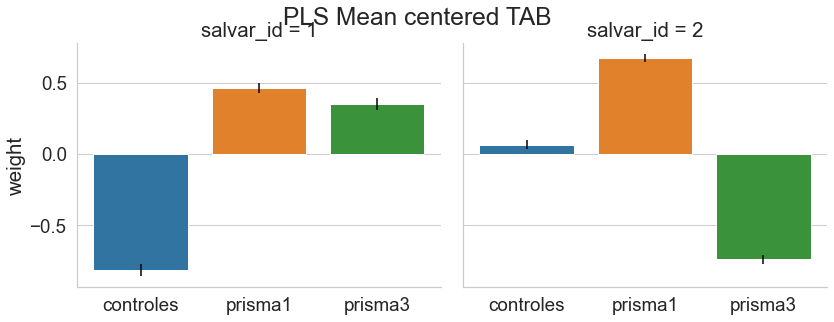

In [46]:
#g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_TAB)

g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, data=y_loadings_m_TAB)

#g.map_dataframe(errplot,  [-0.26,1,1.26,2,2.26], "weight", "err")
g.map_dataframe(errplot,  [0,1,2], "weight", "err")
plt.suptitle('PLS Mean centered TAB')
g.set_xlabels('')


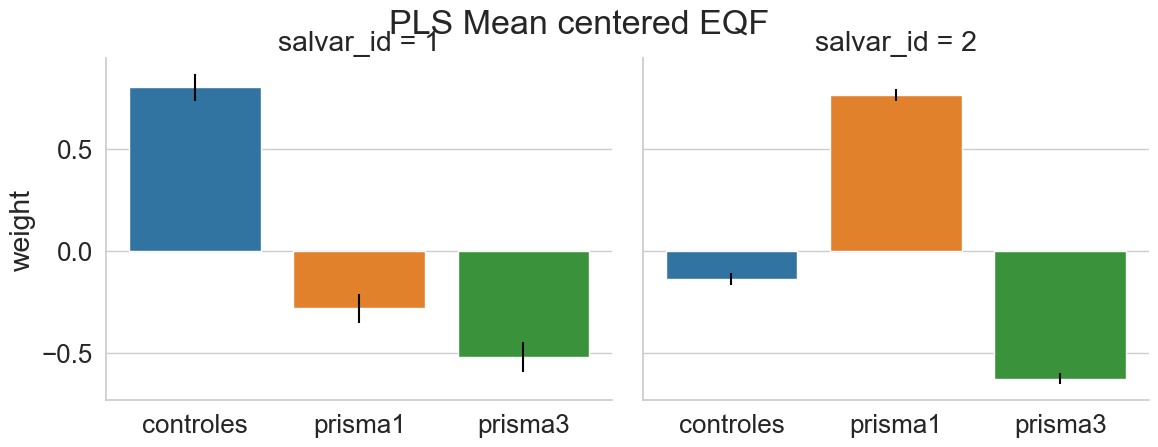

In [47]:
#g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_EQF)
#g.map_dataframe(errplot, [-0.26,1,1.26,2,2.26], "weight", "err")

g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2,data=y_loadings_m_EQF)
g.map_dataframe(errplot, [0,1,2], "weight", "err")

plt.suptitle('PLS Mean centered EQF')
g.set_xlabels('')


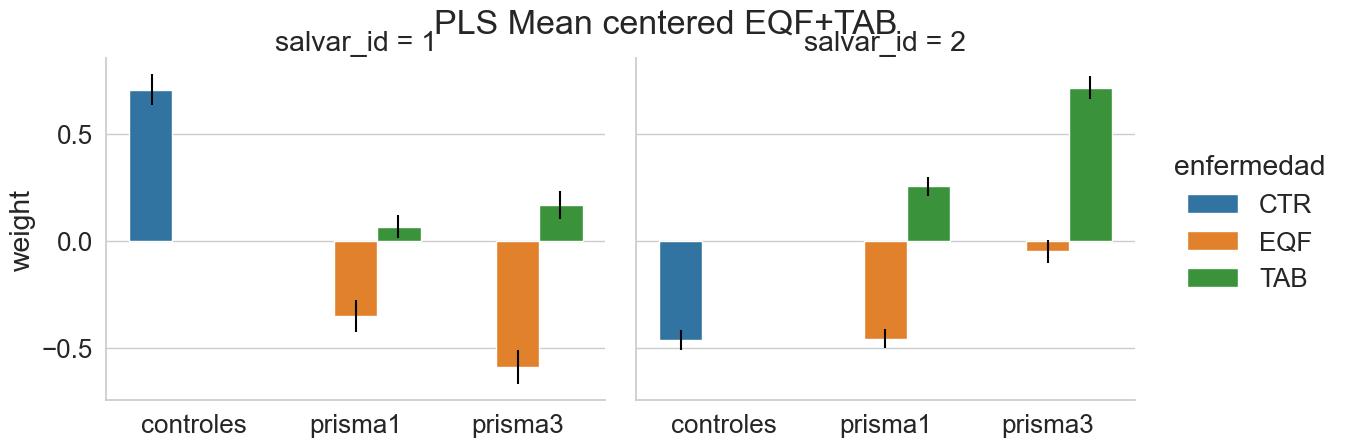

In [48]:
g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="enfermedad",data=y_loadings_m_PSI)
g.map_dataframe(errplot, [-0.26,1,1.26,2,2.26], "weight", "err")

#g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2,data=y_loadings_m_PSI)
#g.map_dataframe(errplot, [0,1,2], "weight", "err")

plt.suptitle('PLS Mean centered EQF+TAB')
g.set_xlabels('')


In [49]:
pls_EQF.permres.pvals

array([3.99920016e-04, 8.61027794e-01, 6.99860028e-01])

In [50]:
pls_EQF.varexp

array([9.82207877e-01, 1.77921231e-02, 1.54402223e-28])

In [51]:
pls_TAB.permres.pvals

array([0.01679664, 0.59708058, 0.84603079])

In [52]:
pls_TAB.varexp

array([9.05080169e-01, 9.49198312e-02, 2.70677599e-28])

In [53]:
pls_PSI.permres.pvals

array([3.99920016e-04, 2.21955609e-01, 5.63887223e-01, 1.00000000e+00,
       4.68506299e-01])

In [54]:
pls_PSI.varexp

array([8.79960464e-01, 8.53878553e-02, 3.36259332e-02, 1.02574705e-03,
       3.00085338e-28])

In [55]:
print(pls_PSI.bootres.x_weights_normed.min(), pls_PSI.bootres.x_weights_normed.max())

-6.473356973259125 5.158168137183444


Gráficos de dispersión

In [56]:
score_EQF = pd.DataFrame()
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['grupo'] = all_data_sorted_EQF['grupo']
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['project'] = all_data_sorted_EQF['project']
score_EQF['treatment'] = all_data_sorted_EQF['treatment']
score_EQF['psc'] = all_data_sorted_EQF['psc'].where(pd.notnull(all_data_sorted_EQF['psc']), -1).astype(int)
score_EQF['Gravedad'] = all_data_sorted_EQF['Gravedad']
score_EQF['x_score_1']=pls_EQF.x_scores[:,0]
score_EQF['y_score_1']=pls_EQF.y_scores[:,0]
score_EQF['x_score_2']=pls_EQF.x_scores[:,1]
score_EQF['y_score_2']=pls_EQF.y_scores[:,1]

score_TAB = pd.DataFrame()
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['grupo'] = all_data_sorted_TAB['grupo']
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['project'] = all_data_sorted_TAB['project']
score_TAB['treatment'] = all_data_sorted_TAB['treatment']
score_TAB['psc'] = all_data_sorted_TAB['psc'].where(pd.notnull(all_data_sorted_TAB['psc']), -1).astype(int)
score_TAB['Gravedad'] = all_data_sorted_TAB['Gravedad']
score_TAB['x_score_1']=pls_TAB.x_scores[:,0]
score_TAB['y_score_1']=pls_TAB.y_scores[:,0]
score_TAB['x_score_2']=pls_TAB.x_scores[:,1]
score_TAB['y_score_2']=pls_TAB.y_scores[:,1]

In [57]:
score_PSI = pd.DataFrame()
score_PSI['subject'] = all_data_sorted_PSI['subject']
score_PSI['grupo'] = all_data_sorted_PSI['grupo']
score_PSI['grupo-p'] = all_data_sorted_PSI['grupo-p']
score_PSI['edad'] = all_data_sorted_PSI['edad']
score_PSI['project'] = all_data_sorted_PSI['project']
score_PSI['treatment'] = all_data_sorted_PSI['treatment']
score_PSI['psc'] = all_data_sorted_PSI['psc'].where(pd.notnull(all_data_sorted_PSI['psc']), -1).astype(int)
score_PSI['Gravedad'] = all_data_sorted_PSI['Gravedad']
score_PSI['x_score_1']=pls_PSI.x_scores[:,0]
score_PSI['y_score_1']=pls_PSI.y_scores[:,0]
score_PSI['x_score_2']=pls_PSI.x_scores[:,1]
score_PSI['y_score_2']=pls_PSI.y_scores[:,1]

In [58]:
score_PSI

subject grupo grupo-p  edad    project  treatment  psc  Gravedad  \
0    CTRL028   CTR     CTR  28.0  controles        0.0    0  0.000000   
22   CTRL003   CTR     CTR  40.0  controles        0.0    0  0.000000   
23   CTRL019   CTR     CTR  31.0  controles        0.0    0  0.000000   
24   CTRL004   CTR     CTR  26.0  controles        0.0    0  0.000000   
25   CTRL011   CTR     CTR  32.0  controles        0.0    0  0.000000   
26   CTRL010   CTR     CTR  33.0  controles        0.0    0  0.000000   
27   CTRL005   CTR     CTR  25.0  controles        0.0    0  0.000000   
28   CTRL018   CTR     CTR  38.0  controles        0.0    0  0.000000   
30   CTRL017   CTR     CTR  28.0  controles        0.0    0  0.000000   
31   CTRL015   CTR     CTR  46.0  controles        0.0    0  0.000000   
32   CTRL008   CTR     CTR  27.0  controles        0.0    0  0.000000   
33   CTRL012   CTR     CTR  55.0  controles        0.0    0  0.000000   
34   CTRL007   CTR     CTR  39.0  controles        0.0    0  0.000000   
35   CTRL006   CTR     CTR  25.0  controles        0.0    0  0.000000   
36   CTRL013   CTR     CTR  49.0  controles        0.0    0  0.000000   
37   CTRL009   CTR     CTR  43.0  controles        0.0    0  0.000000   
38   CTRL014   CTR     CTR  21.0  controles        0.0    0  0.000000   
39   CTRL001   CTR     CTR  44.0  controles        0.0    0  0.000000   
21   CTRL016   CTR     CTR  44.0  controles        0.0    0  0.000000   
20   CTRL037   CTR     CTR  31.0  controles        0.0    0  0.000000   
29   CTRL002   CTR     CTR  44.0  controles        0.0    0  0.000000   
18   CTRL025   CTR     CTR  49.0  controles        0.0    0  0.000000   
19   CTRL022   CTR     CTR  67.0  controles        0.0    0  0.000000   
2    CTRL035   CTR     CTR  29.0  controles        0.0    0  0.000000   
3    CTRL032   CTR     CTR  24.0  controles        0.0    0  0.000000   
4    CTRL027   CTR     CTR  41.0  controles        0.0    0  0.000000   
5    CTRL026   CTR     CTR  56.0  controles        0.0    0  0.000000   
6    CTRL033   CTR     CTR  25.0  controles        0.0    0  0.000000   
7    CTRL034   CTR     CTR  30.0  controles        0.0    0  0.000000   
8    CTRL021   CTR     CTR  37.0  controles        0.0    0  0.000000   
9    CTRL029   CTR     CTR  20.0  controles        0.0    0  0.000000   
1    CTRL020   CTR     CTR  58.0  controles        0.0    0  0.000000   
11   CTRL023   CTR     CTR  28.0  controles        0.0    0  0.000000   
12   CTRL024   CTR     CTR  37.0  controles        0.0    0  0.000000   
13   CTRL031   CTR     CTR  41.0  controles        0.0    0  0.000000   
14   CTRL040   CTR     CTR  55.0  controles        0.0    0  0.000000   
15   CTRL039   CTR     CTR  23.0  controles        0.0    0  0.000000   
16   CTRL038   CTR     CTR  26.0  controles        0.0    0  0.000000   
17   CTRL030   CTR     CTR  62.0  controles        0.0    0  0.000000   
10   CTRL036   CTR     CTR  19.0  controles        0.0    0  0.000000   
133  EQFP048   EQF     PSI  24.0    prisma1        1.0    1  2.142857   
115  EQFP037   EQF     PSI  47.0    prisma1        2.0    1  0.137931   
124  EQFP052   EQF     PSI  24.0    prisma1        1.0    1  1.000000   
132  EQFP039   EQF     PSI  33.0    prisma1        NaN    1  0.000000   
127  EQFP036   EQF     PSI  21.0    prisma1        2.0    1  4.000000   
128  EQFP023   EQF     PSI  52.0    prisma1        1.0    1  0.150000   
114  EQFP022   EQF     PSI  28.0    prisma1        NaN    1  0.454545   
125  EQFP047   EQF     PSI  23.0    prisma1        1.0    1  1.500000   
111  EQFP053   EQF     PSI  59.0    prisma1        2.0    1  0.115385   
102  EQFP030   EQF     PSI  46.0    prisma1        1.0    1  0.000000   
105  EQFP038   EQF     PSI  30.0    prisma1        2.0    1  1.000000   
103  EQFP025   EQF     PSI  27.0    prisma1        1.0    1  0.714286   
99   EQFP041   EQF     PSI  30.0    prisma1        1.0    1  0.000000   
98   EQFP054   EQF     PSI  21.0    prisma1        1.0    1  0.

In [59]:
#color = {0: 'w', 1: 'k', 100: 'r'}
color = {0: 'w', 1: 'k', -1: 'r'}
#color = {'controles':'w','prisma1': 'w','prisma3':'k'}
le = LabelEncoder()
subject_n = pd.factorize(score_TAB.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_TAB['subject_color'] = le.fit_transform(subject_n)
score_TAB['edge_color'] = score_TAB.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

lee = LabelEncoder()
subject_n = pd.factorize(score_EQF.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_EQF['subject_color'] = lee.fit_transform(subject_n)
score_EQF['edge_color'] = score_EQF.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

In [60]:
color = {0: 'w', 1: 'k', -1: 'r'}
lep = LabelEncoder()
subject_n = pd.factorize(score_PSI.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_PSI['subject_color'] = lep.fit_transform(subject_n)
score_PSI['edge_color'] = score_PSI.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

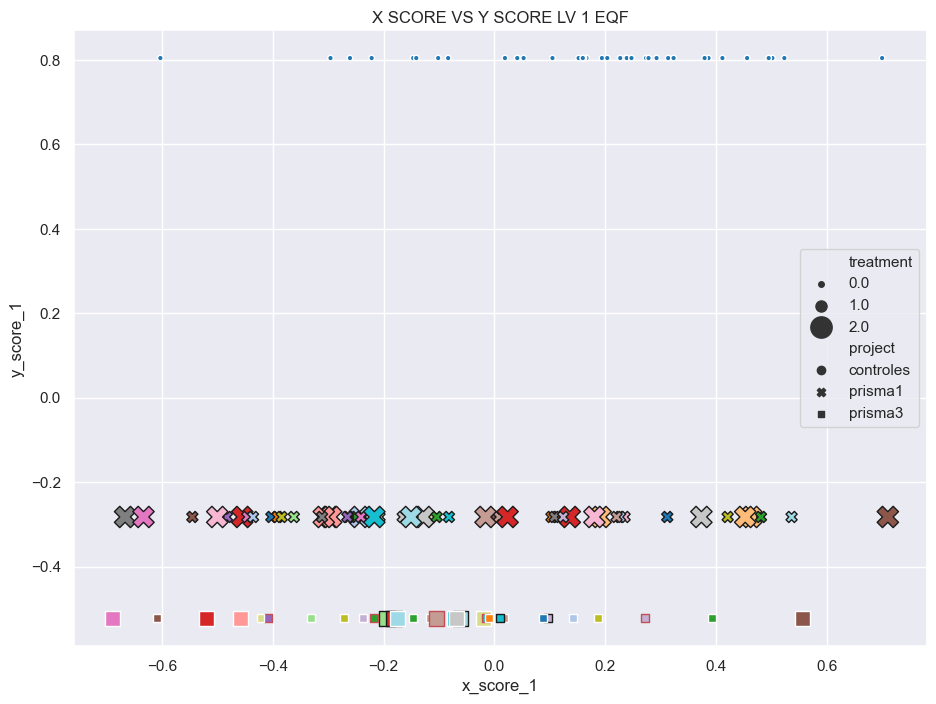

In [77]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                  hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                  palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[61:]
selected_labels = current_labels[61:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF")
plt.show()

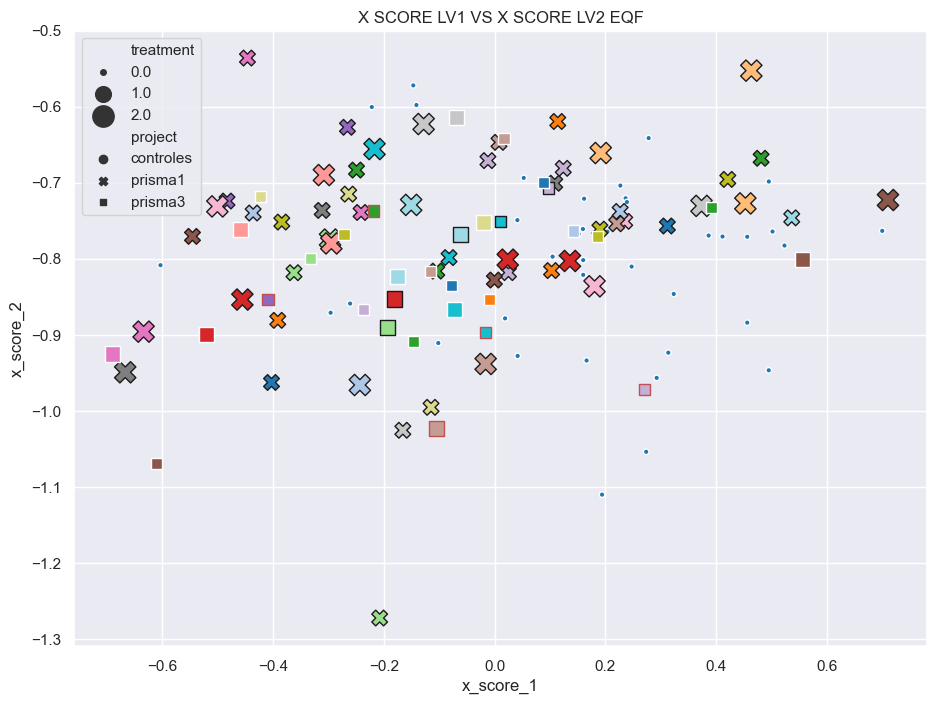

In [78]:
# Gráfico variable latente 1 vs variable latente 2
sns.set(rc={'figure.figsize':(11,8)})
        
g=sns.scatterplot(x="x_score_1", y="x_score_2",
                  hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=True,
                  palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)


current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[61:]
selected_labels = current_labels[61:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 EQF")
plt.show()

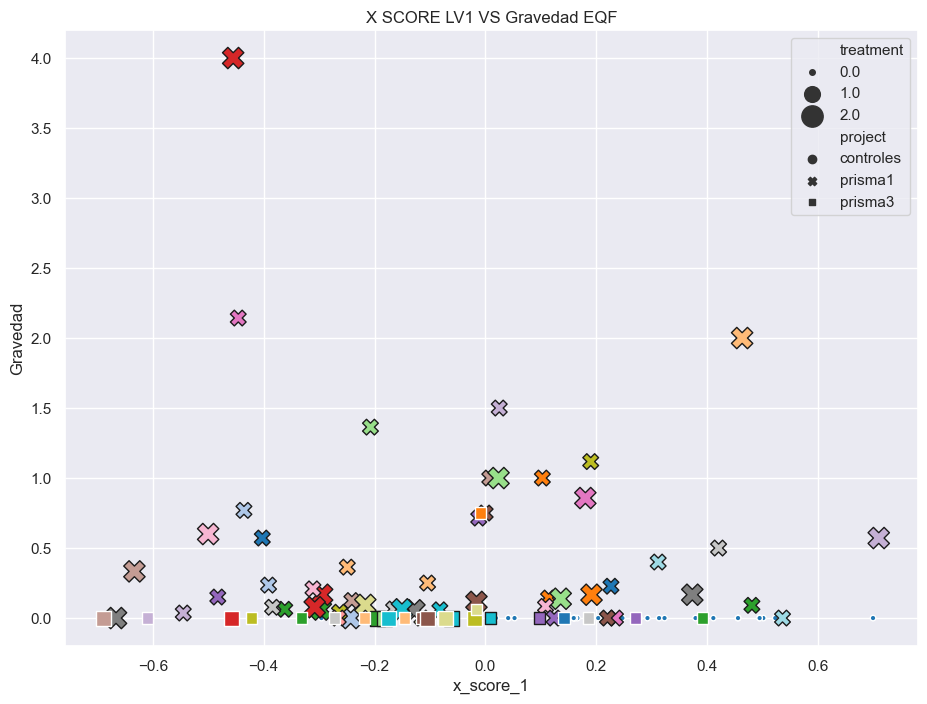

In [79]:
# Gráfico variable latente 1 vs gravedad
score_EQF_na = score_EQF.dropna(subset=['Gravedad'])
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                palette='tab20',data=score_EQF_na,edgecolor=score_EQF_na["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[60:]
selected_labels = current_labels[60:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad EQF")
plt.show()

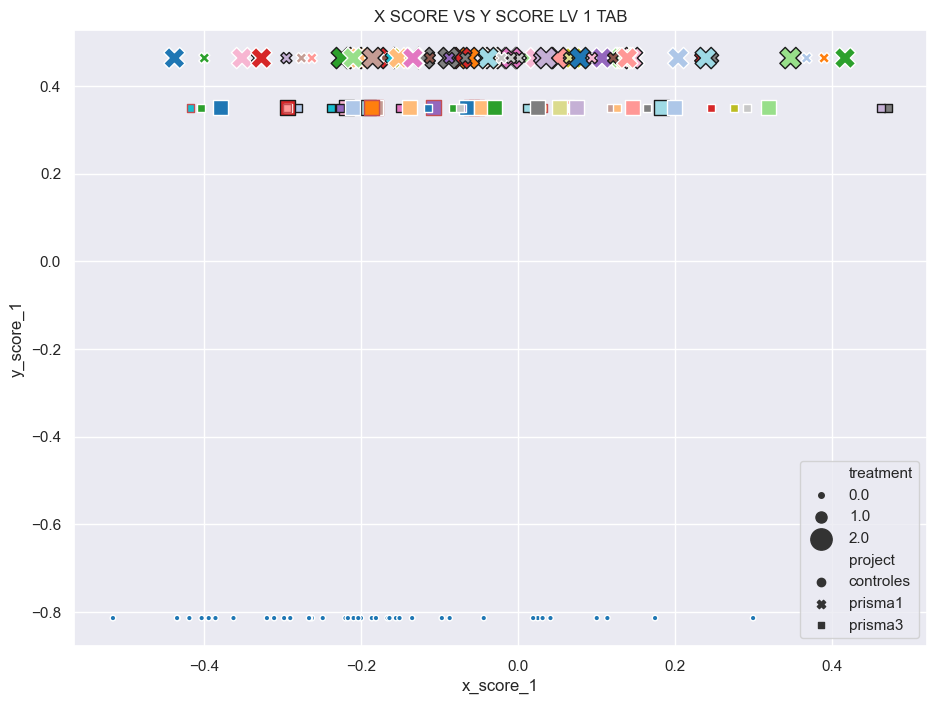

In [80]:
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                 hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[83:]
selected_labels = current_labels[83:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 TAB")
plt.show()

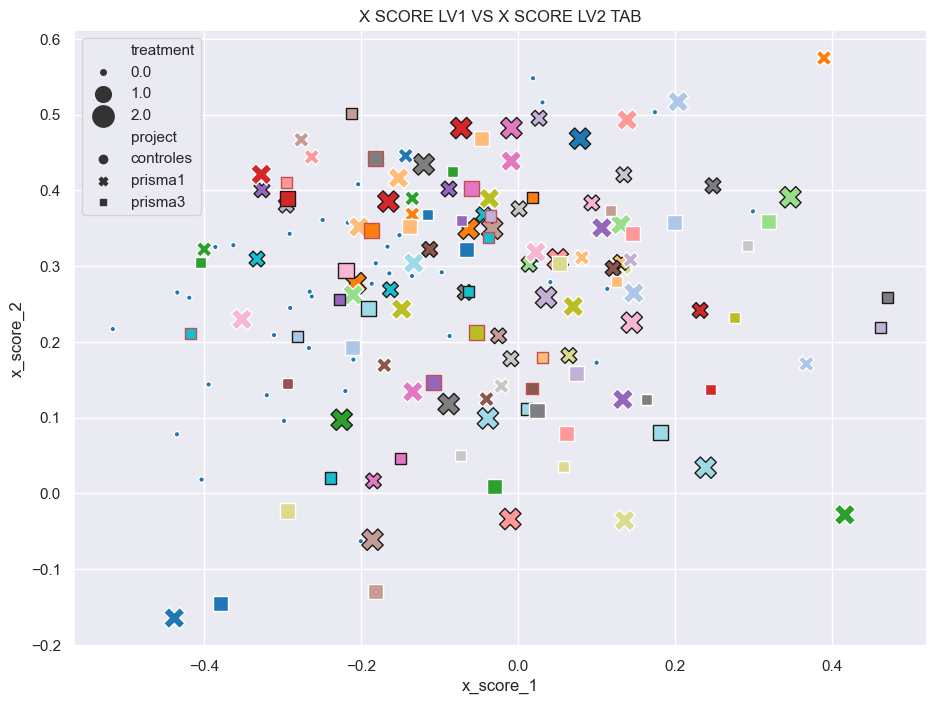

In [81]:
#sns.set(rc={'figure.figsize':(11,8)})
g= sns.scatterplot(x="x_score_1", y="x_score_2",
                hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=True,
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)

current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[83:]
selected_labels = current_labels[83:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 TAB")
plt.show()


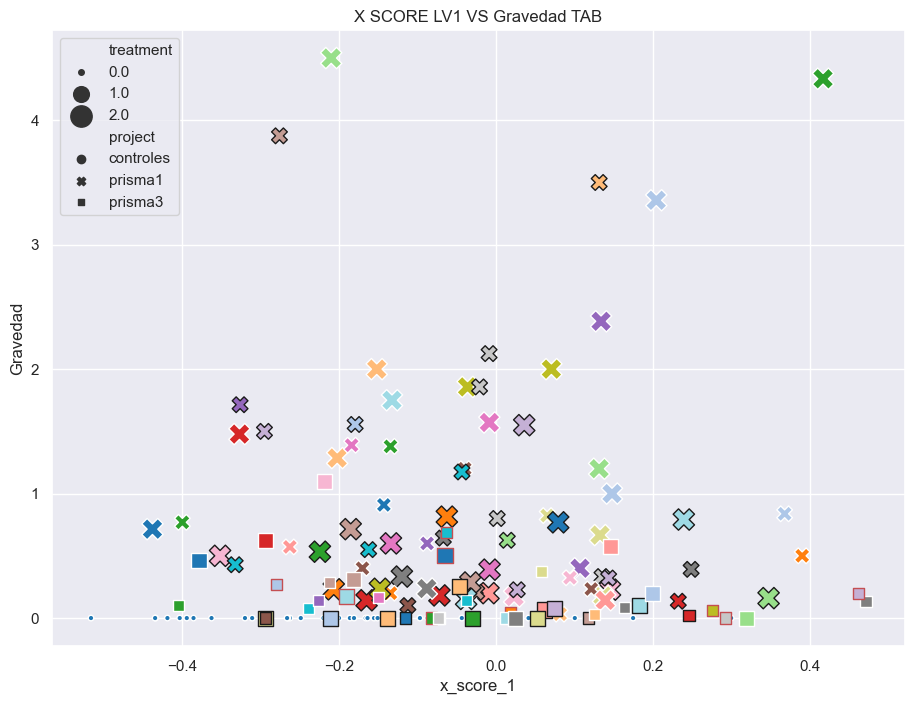

In [82]:
score_TAB_na = score_TAB.dropna(subset=['Gravedad'])
markers = {0.0: "X", 1.0: "o",2.0:"s"}
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                  hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                  palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[83:]
selected_labels = current_labels[83:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad TAB")
plt.show()

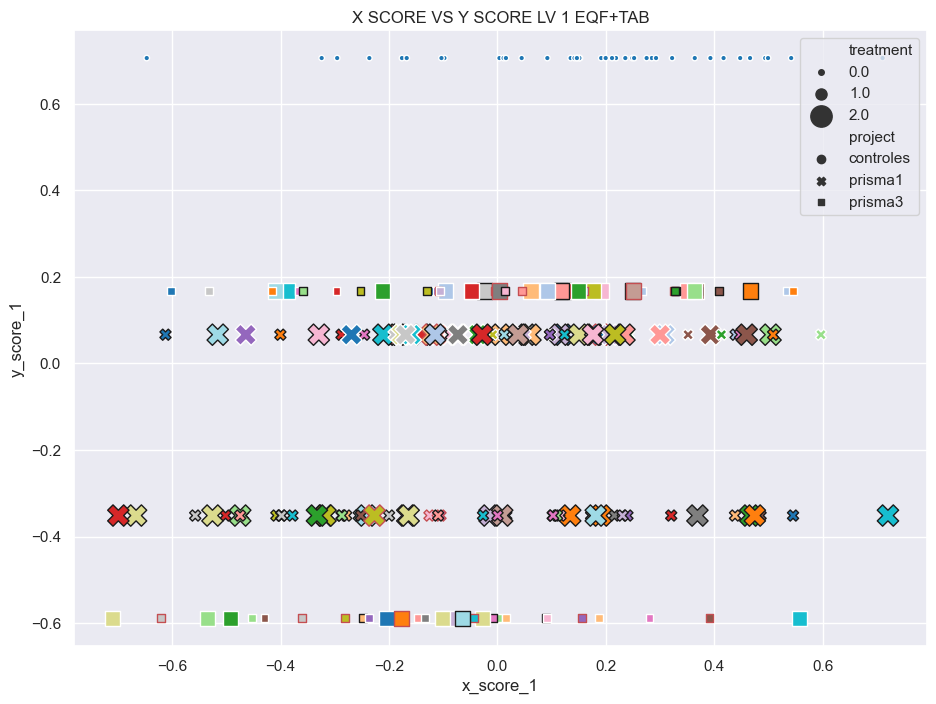

In [83]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                  hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                  palette='tab20',data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[147:]
selected_labels = current_labels[147:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF+TAB")
plt.show()

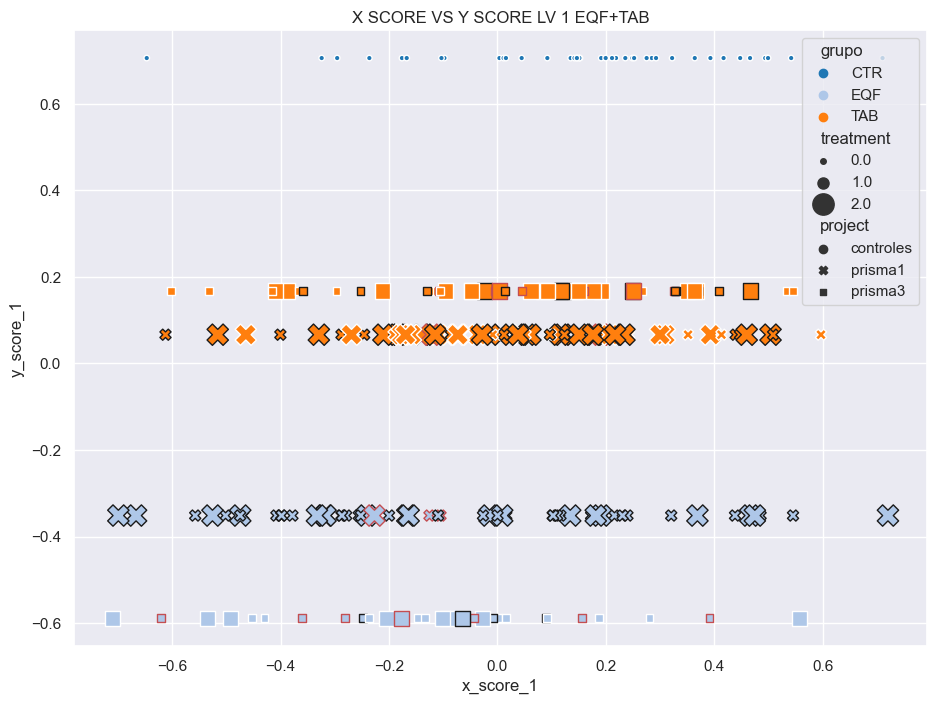

In [68]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                  hue="grupo", style="project", size='treatment',sizes=[16,64,236],
                  palette='tab20',data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
#current_handles, current_labels = g.get_legend_handles_labels()
#selected_handles = current_handles[146:]
#selected_labels = current_labels[146:]
#plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF+TAB")
plt.show()

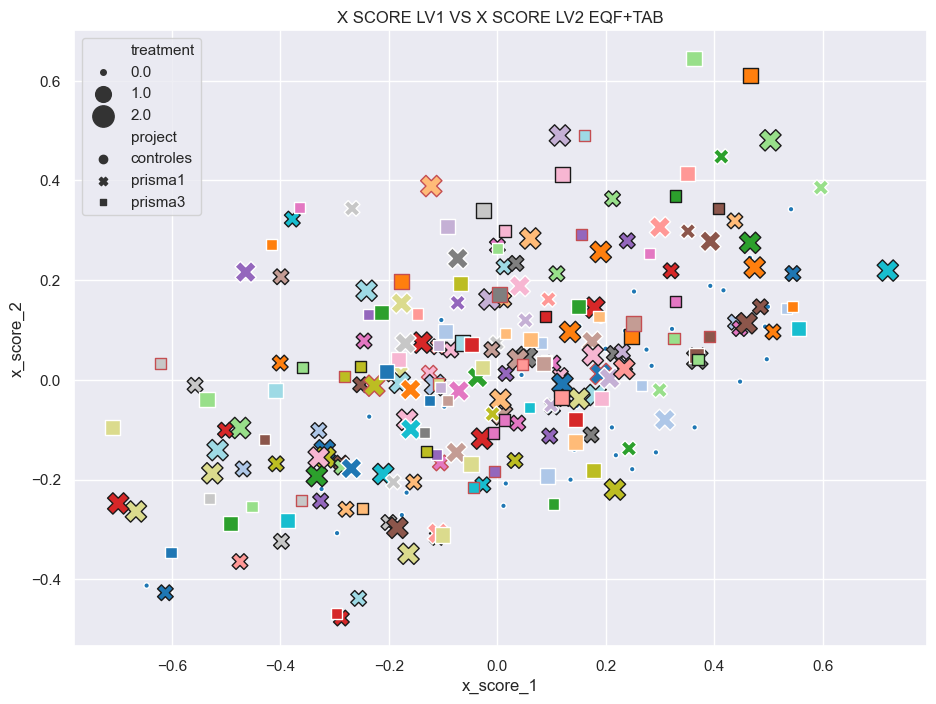

In [84]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="x_score_2",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=True,
                palette='tab20',data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[147:]
selected_labels = current_labels[147:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 EQF+TAB")
plt.show()

In [70]:
sizes = {'CTR': 128, 'EQF':236 ,'TAB':236}
score_PSI['grupo-size'] = score_PSI.apply(lambda x: sizes[x['grupo']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)
score_PSI

subject grupo grupo-p  edad    project  treatment  psc  Gravedad  \
0    CTRL028   CTR     CTR  28.0  controles        0.0    0  0.000000   
22   CTRL003   CTR     CTR  40.0  controles        0.0    0  0.000000   
23   CTRL019   CTR     CTR  31.0  controles        0.0    0  0.000000   
24   CTRL004   CTR     CTR  26.0  controles        0.0    0  0.000000   
25   CTRL011   CTR     CTR  32.0  controles        0.0    0  0.000000   
26   CTRL010   CTR     CTR  33.0  controles        0.0    0  0.000000   
27   CTRL005   CTR     CTR  25.0  controles        0.0    0  0.000000   
28   CTRL018   CTR     CTR  38.0  controles        0.0    0  0.000000   
30   CTRL017   CTR     CTR  28.0  controles        0.0    0  0.000000   
31   CTRL015   CTR     CTR  46.0  controles        0.0    0  0.000000   
32   CTRL008   CTR     CTR  27.0  controles        0.0    0  0.000000   
33   CTRL012   CTR     CTR  55.0  controles        0.0    0  0.000000   
34   CTRL007   CTR     CTR  39.0  controles        0.0    0  0.000000   
35   CTRL006   CTR     CTR  25.0  controles        0.0    0  0.000000   
36   CTRL013   CTR     CTR  49.0  controles        0.0    0  0.000000   
37   CTRL009   CTR     CTR  43.0  controles        0.0    0  0.000000   
38   CTRL014   CTR     CTR  21.0  controles        0.0    0  0.000000   
39   CTRL001   CTR     CTR  44.0  controles        0.0    0  0.000000   
21   CTRL016   CTR     CTR  44.0  controles        0.0    0  0.000000   
20   CTRL037   CTR     CTR  31.0  controles        0.0    0  0.000000   
29   CTRL002   CTR     CTR  44.0  controles        0.0    0  0.000000   
18   CTRL025   CTR     CTR  49.0  controles        0.0    0  0.000000   
19   CTRL022   CTR     CTR  67.0  controles        0.0    0  0.000000   
2    CTRL035   CTR     CTR  29.0  controles        0.0    0  0.000000   
3    CTRL032   CTR     CTR  24.0  controles        0.0    0  0.000000   
4    CTRL027   CTR     CTR  41.0  controles        0.0    0  0.000000   
5    CTRL026   CTR     CTR  56.0  controles        0.0    0  0.000000   
6    CTRL033   CTR     CTR  25.0  controles        0.0    0  0.000000   
7    CTRL034   CTR     CTR  30.0  controles        0.0    0  0.000000   
8    CTRL021   CTR     CTR  37.0  controles        0.0    0  0.000000   
9    CTRL029   CTR     CTR  20.0  controles        0.0    0  0.000000   
1    CTRL020   CTR     CTR  58.0  controles        0.0    0  0.000000   
11   CTRL023   CTR     CTR  28.0  controles        0.0    0  0.000000   
12   CTRL024   CTR     CTR  37.0  controles        0.0    0  0.000000   
13   CTRL031   CTR     CTR  41.0  controles        0.0    0  0.000000   
14   CTRL040   CTR     CTR  55.0  controles        0.0    0  0.000000   
15   CTRL039   CTR     CTR  23.0  controles        0.0    0  0.000000   
16   CTRL038   CTR     CTR  26.0  controles        0.0    0  0.000000   
17   CTRL030   CTR     CTR  62.0  controles        0.0    0  0.000000   
10   CTRL036   CTR     CTR  19.0  controles        0.0    0  0.000000   
133  EQFP048   EQF     PSI  24.0    prisma1        1.0    1  2.142857   
115  EQFP037   EQF     PSI  47.0    prisma1        2.0    1  0.137931   
124  EQFP052   EQF     PSI  24.0    prisma1        1.0    1  1.000000   
132  EQFP039   EQF     PSI  33.0    prisma1        NaN    1  0.000000   
127  EQFP036   EQF     PSI  21.0    prisma1        2.0    1  4.000000   
128  EQFP023   EQF     PSI  52.0    prisma1        1.0    1  0.150000   
114  EQFP022   EQF     PSI  28.0    prisma1        NaN    1  0.454545   
125  EQFP047   EQF     PSI  23.0    prisma1        1.0    1  1.500000   
111  EQFP053   EQF     PSI  59.0    prisma1        2.0    1  0.115385   
102  EQFP030   EQF     PSI  46.0    prisma1        1.0    1  0.000000   
105  EQFP038   EQF     PSI  30.0    prisma1        2.0    1  1.000000   
103  EQFP025   EQF     PSI  27.0    prisma1        1.0    1  0.714286   
99   EQFP041   EQF     PSI  30.0    prisma1        1.0    1  0.000000   
98   EQFP054   EQF     PSI  21.0    prisma1        1.0    1  0.

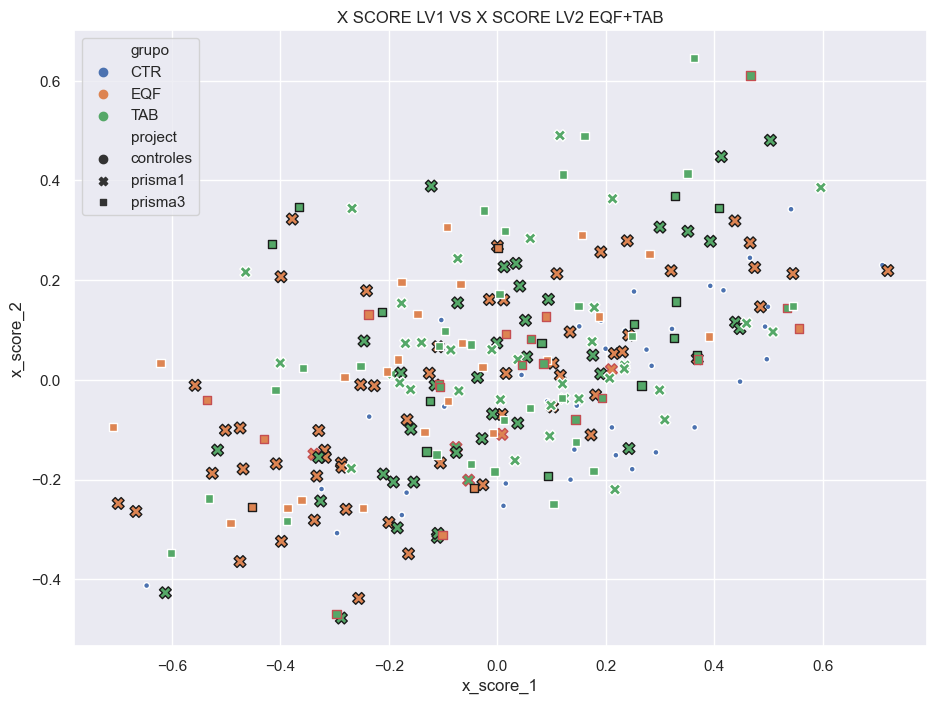

In [85]:
g=sns.scatterplot(x="x_score_1", y="x_score_2", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)

current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 EQF+TAB")
plt.show()

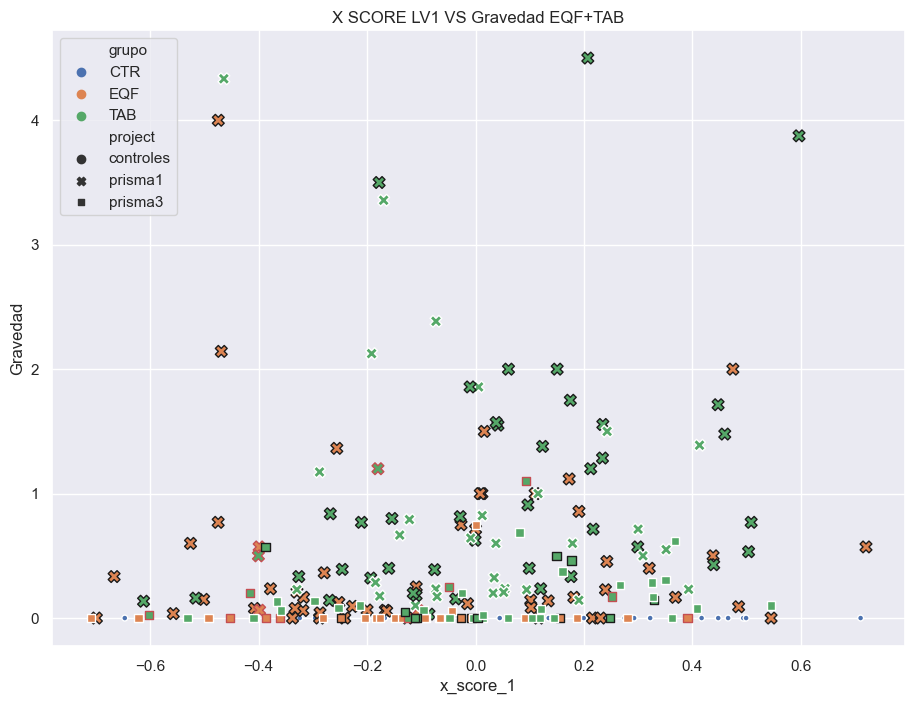

In [86]:
score_PSI_na = score_PSI.dropna(subset=['Gravedad'])
#g=sns.scatterplot(x="x_score_1", y="Gravedad",
#                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
#                palette='tab20',data=score_PSI_na,edgecolor=score_PSI_na["edge_color"],linewidth=1)
g=sns.scatterplot(x="x_score_1", y="Gravedad", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad EQF+TAB")
plt.show()

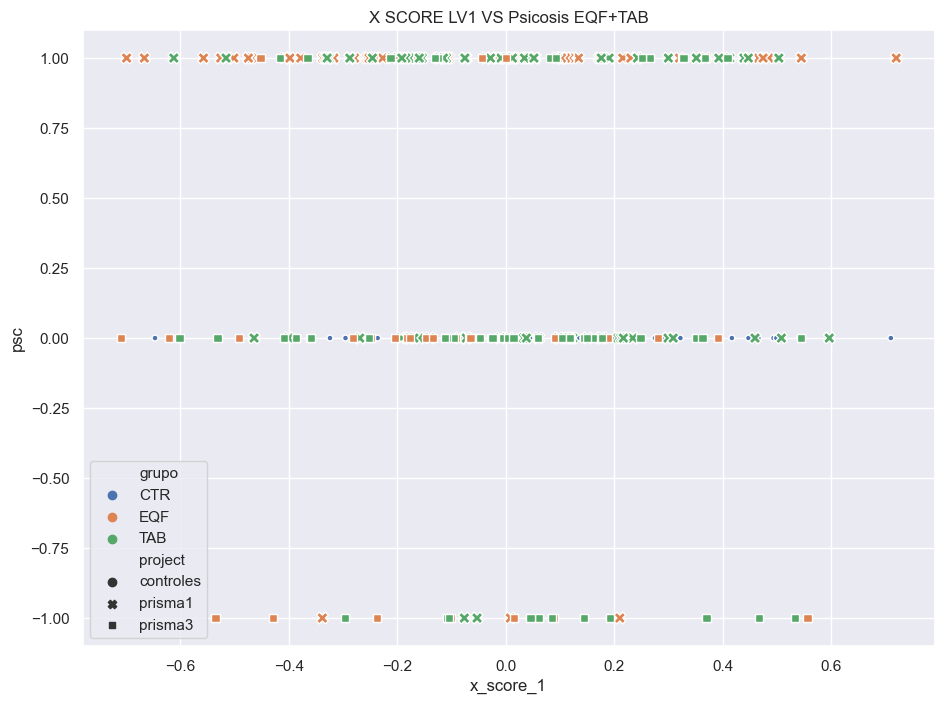

In [73]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="psc", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Psicosis EQF+TAB")
plt.show()

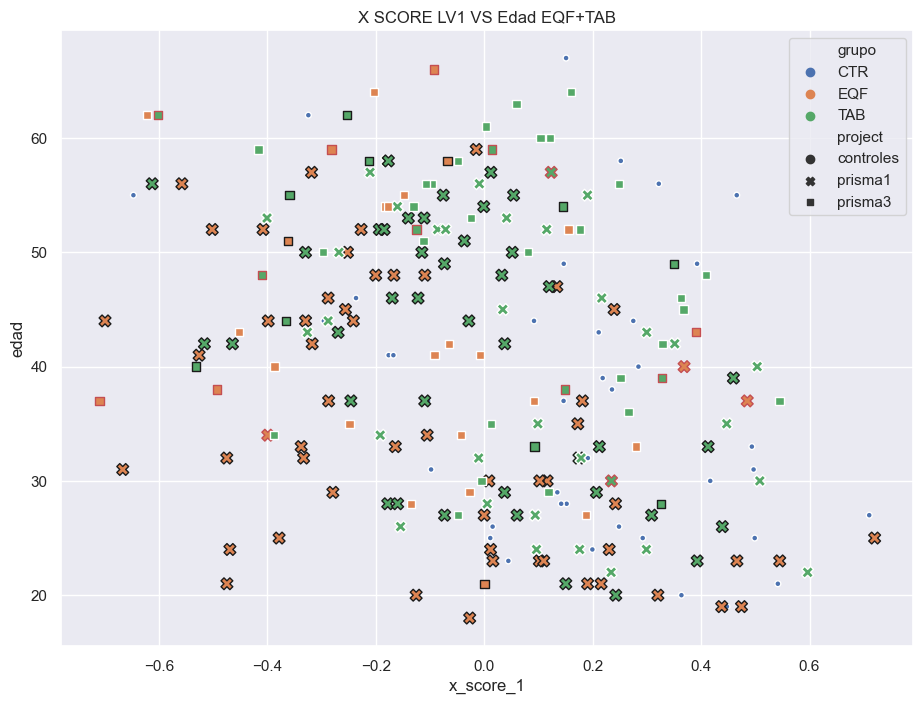

In [74]:
sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="edad", size=score_PSI['grupo-size'],
                  hue="grupo", style="project",legend=True,
                  data=score_PSI,edgecolor=score_PSI["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[0:4]
selected_handles.extend(current_handles[7:11])
selected_labels = current_labels[0:4]
selected_labels.extend(current_labels[7:11])
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Edad EQF+TAB")
plt.show()

## X Weights

In [75]:
yeo_pal = {'Vis': (0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 'SomMot': (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 'DorsAttn': (0.0, 0.4627450980392157, 0.054901960784313725),
 'SalVentAttn': (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 'Limbic': (0.8627450980392157, 0.9725490196078431, 0.6431372549019608),
 'Cont': (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 'Default': (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 'None': (0.7, 0.7, 0.7, 0.5),
 'TempPar': 'blue'}

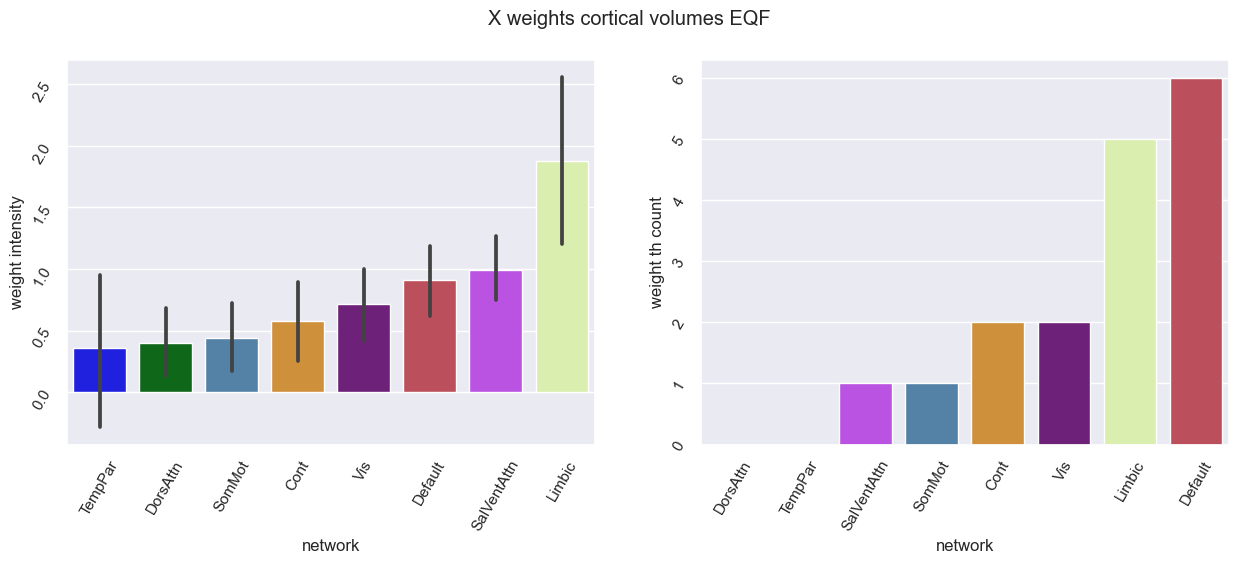

In [89]:
EQF_data = all_data_sorted_EQF.iloc[:,3:-6] # Selecciona sólo los datos de volúmenes 
networks7_order = pd.read_csv('Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter=' ')

sch_x_sch_weights_EQF = pls_EQF.bootres.x_weights_normed[50:,0] # Selección variables corticales
df_x_weights_sch_EQF = pd.DataFrame(sch_x_sch_weights_EQF, columns=["weight"])
df_x_weights_sch_EQF.index = networks7_order[1]
df_x_weights_sch_EQF["network"] = df_x_weights_sch_EQF.index.str.split('_').str.get(2)

df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch_EQF.loc[df_x_weights_sch_EQF.network.str.contains('Default'), 'network'] = 'Default'

th = 3 
df_x_weights_sch_EQF["weight_th"] =  (abs(df_x_weights_sch_EQF["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF')

order_g = df_x_weights_sch_EQF.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], palette=yeo_pal,
                order=order_g, data=df_x_weights_sch_EQF)

g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_EQF.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum, palette=yeo_pal,
                order=order_h, data=df_x_weights_sch_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)


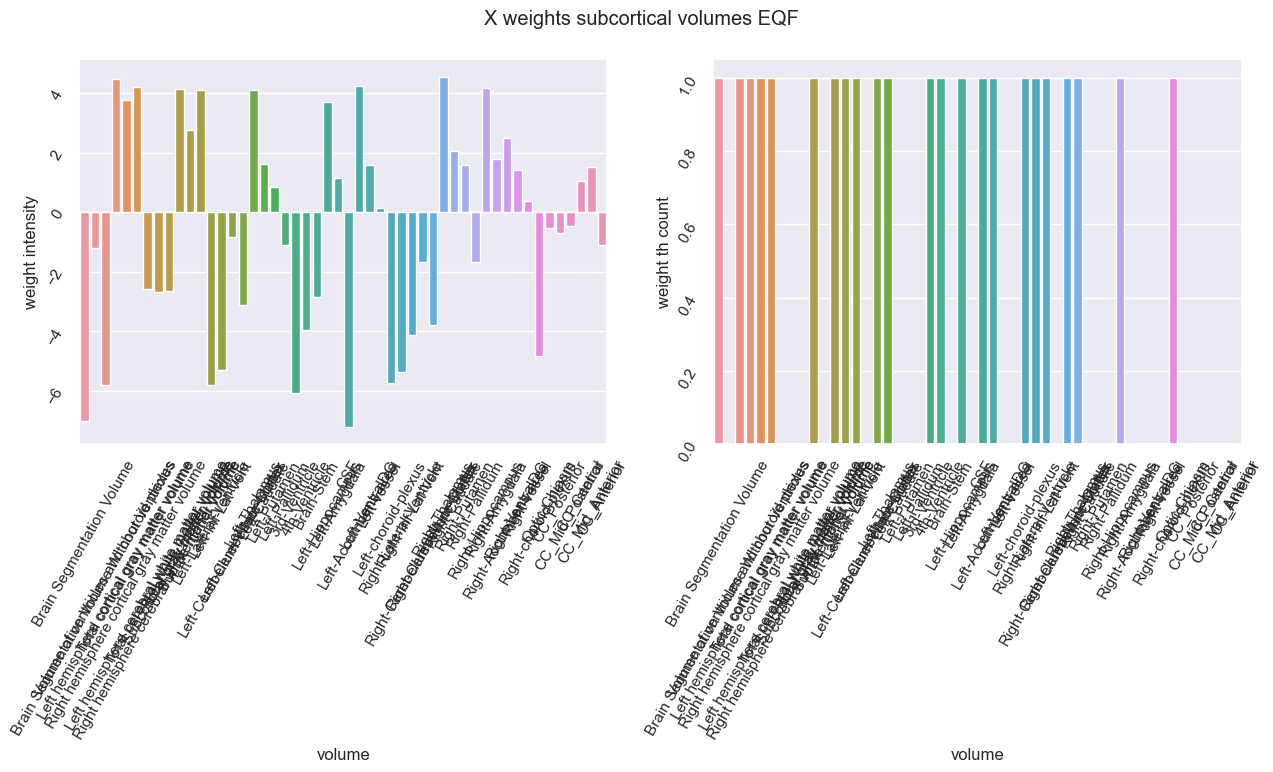

In [90]:
sch_x_v_weights_EQF = pls_EQF.bootres.x_weights_normed[:50,0]
df_x_weights_v_EQF = pd.DataFrame(sch_x_v_weights_EQF, columns=["weight"])
df_x_weights_v_EQF['volume'] = list(EQF_data.iloc[:,:50].columns)
#df_x_weights_v_EQF['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_EQF["weight_th"] =  (abs(df_x_weights_v_EQF["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes EQF')

#g=sns.barplot(x="category", y="weight", ci=None, ax=axes[0],
#            data=df_x_weights_v_EQF)
g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
              data=df_x_weights_v_EQF)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

/opt/miniconda3/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



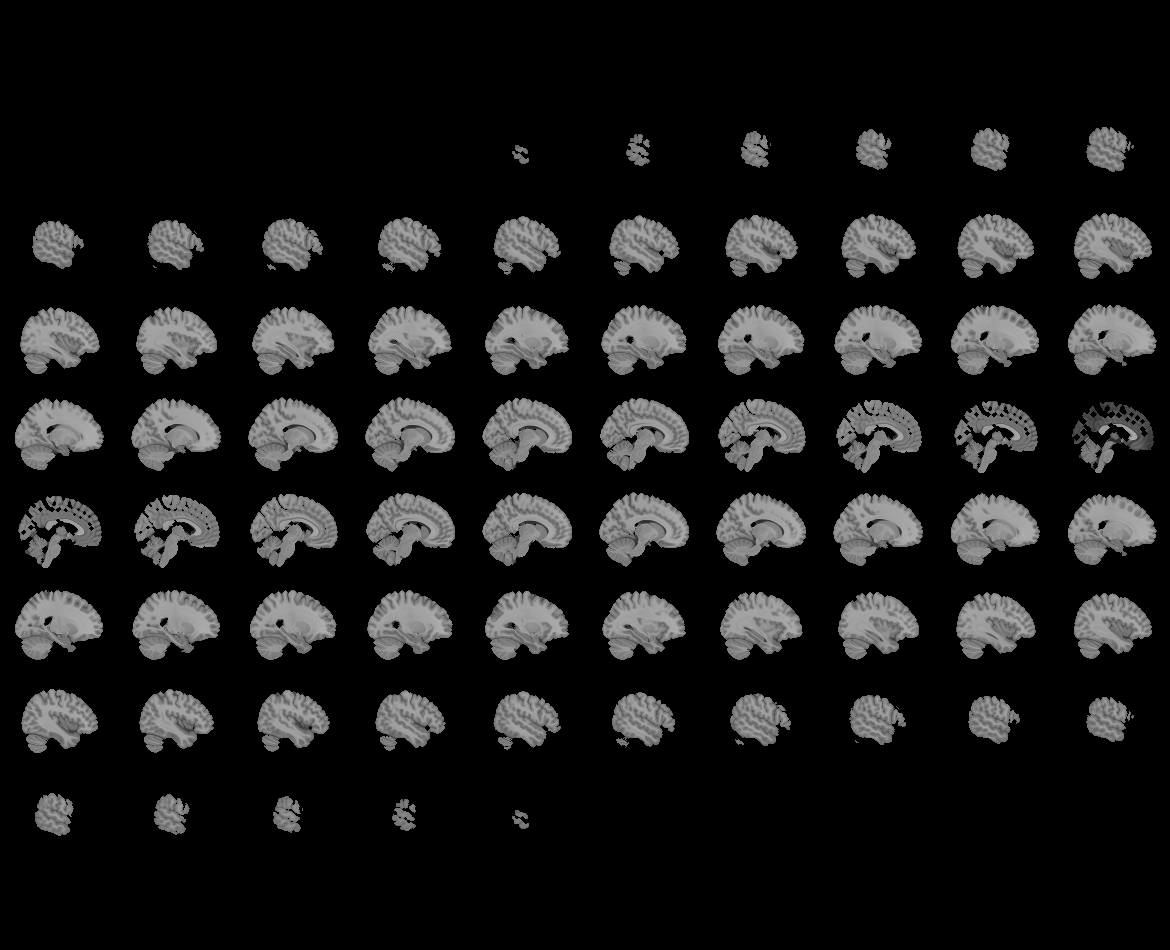
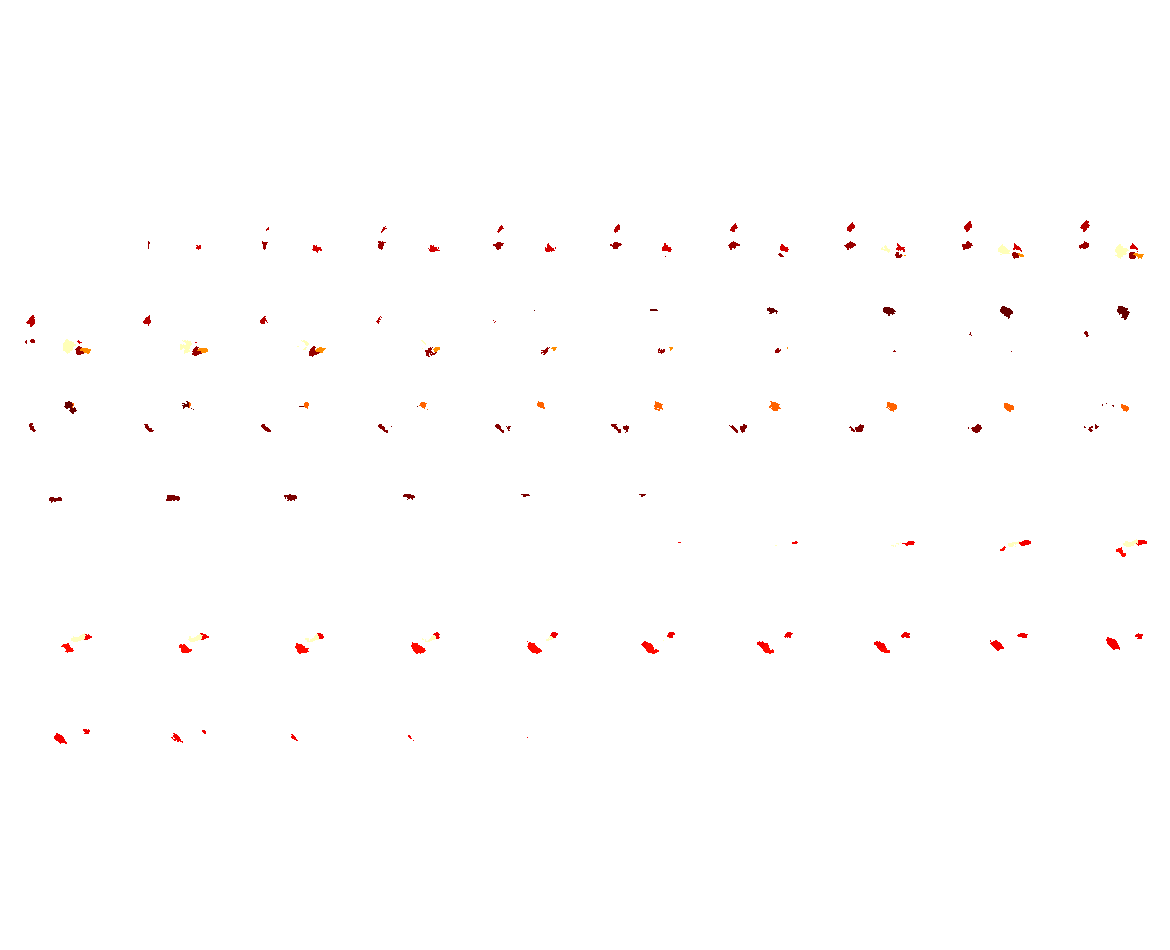

In [91]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th = 3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_EQF[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights EQF', symmetric_cmap=False)

## TAB

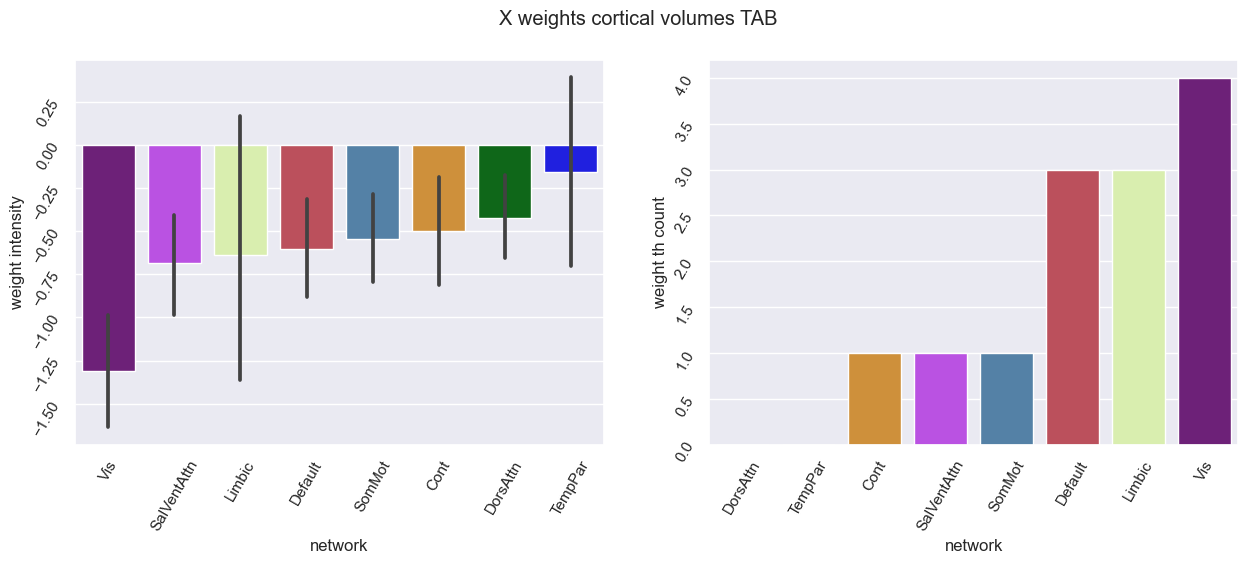

In [92]:
TAB_data = all_data_sorted_TAB.iloc[:,3:-6]
networks7_order = pd.read_csv('Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter='\t')
sch_x_sch_weights_TAB = pls_TAB.bootres.x_weights_normed[50:,0]
df_x_weights_sch_TAB = pd.DataFrame(sch_x_sch_weights_TAB, columns=["weight"])
df_x_weights_sch_TAB.index = networks7_order[1]
df_x_weights_sch_TAB["network"] = df_x_weights_sch_TAB.index.str.split('_').str.get(2)

df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch_TAB.loc[df_x_weights_sch_TAB.network.str.contains('Default'), 'network'] = 'Default'

th = 3
df_x_weights_sch_TAB["weight_th"] =  (abs(df_x_weights_sch_TAB["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes TAB')

order_g = df_x_weights_sch_TAB.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_TAB.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

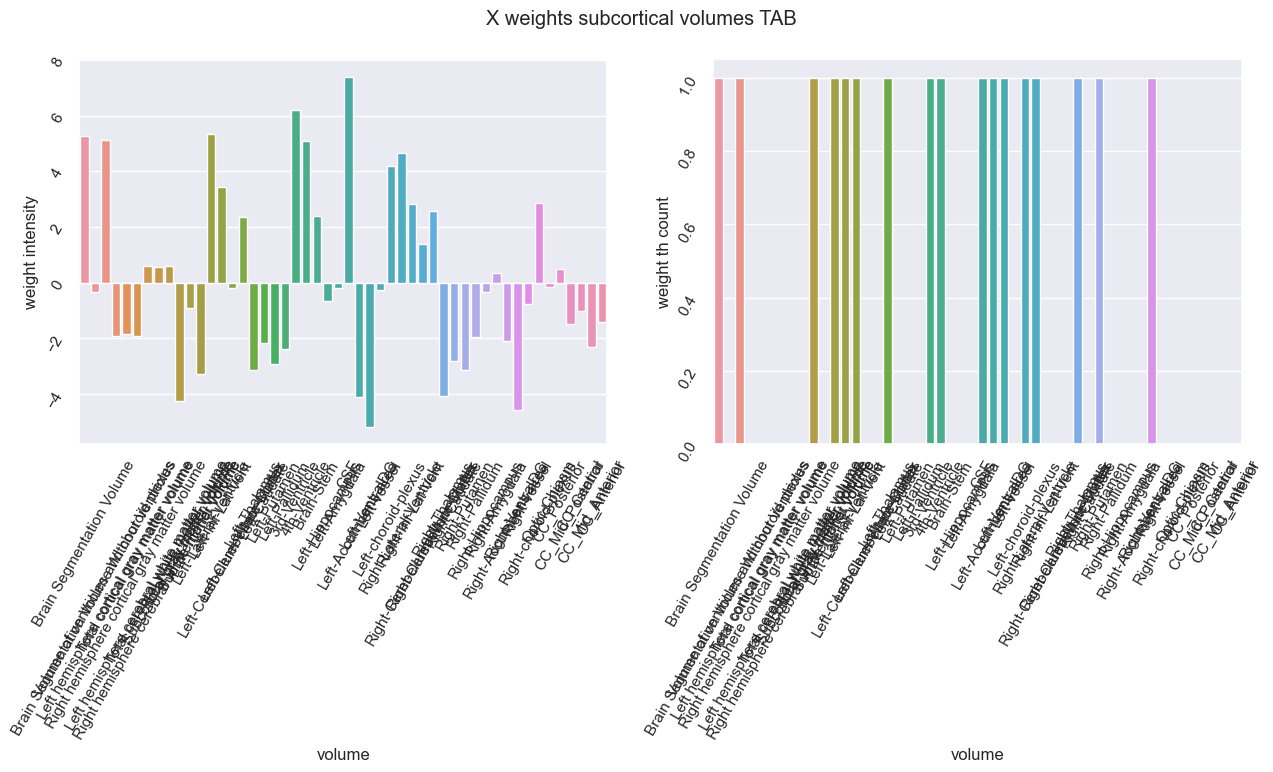

In [93]:
sch_x_v_weights_TAB = pls_TAB.bootres.x_weights_normed[:50,0]
df_x_weights_v_TAB = pd.DataFrame(sch_x_v_weights_TAB, columns=["weight"])
df_x_weights_v_TAB['volume'] = list(TAB_data.iloc[:,:50].columns)
#df_x_weights_v_TAB['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_TAB["weight_th"] =  (abs(df_x_weights_v_TAB["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes TAB')

g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

/opt/miniconda3/lib/python3.9/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '



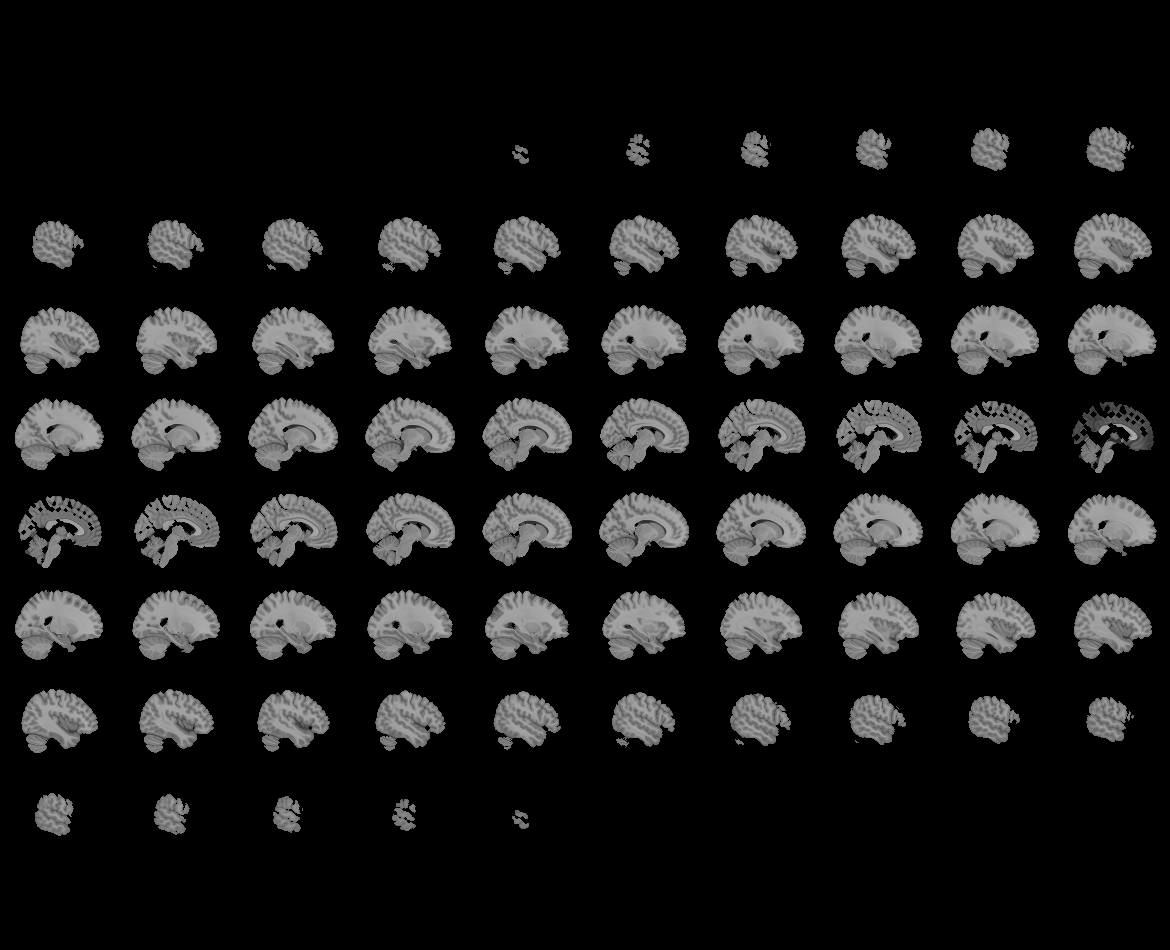
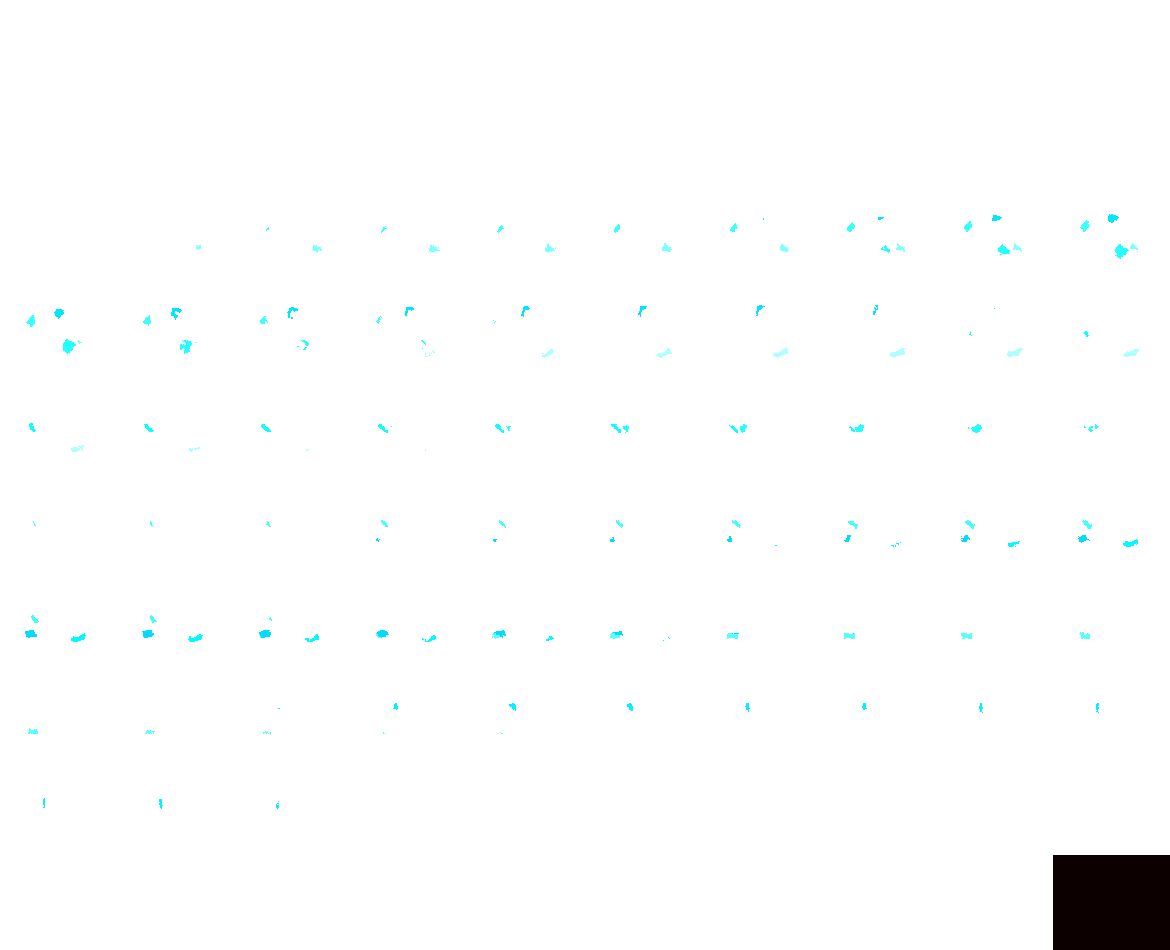

In [94]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
#th = max(sch_x_sch_weights_TAB)*0.6
th=3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_TAB[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights TAB', symmetric_cmap=False)

EQF+TAB

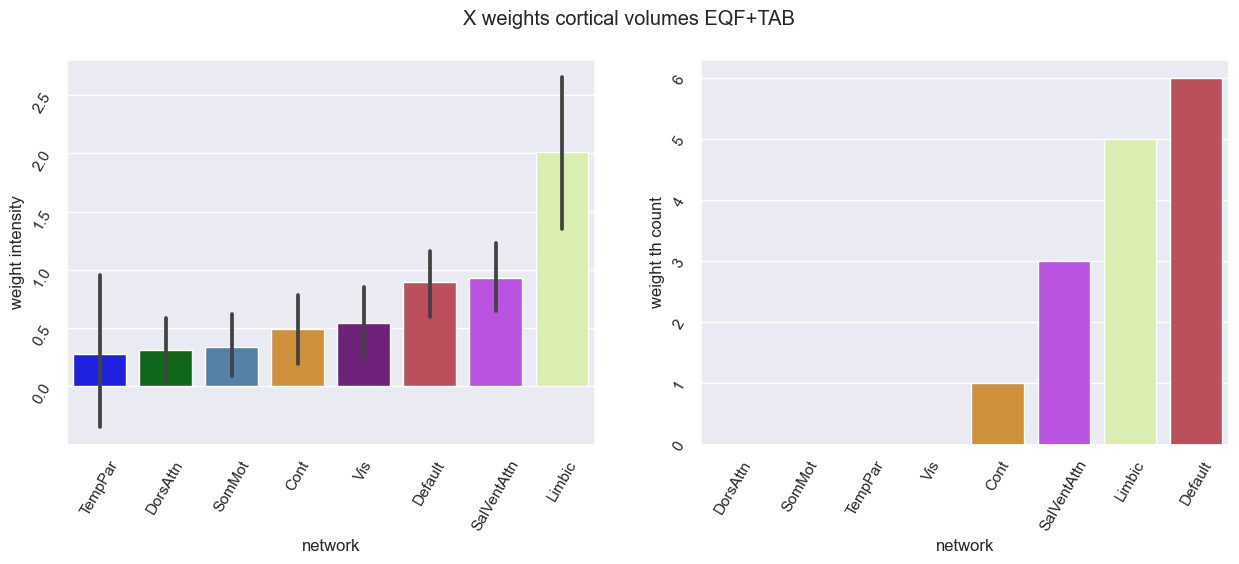

In [108]:
PSI_data = all_data_sorted_PSI.iloc[:,3:-7]
networks7_order = pd.read_csv('Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter='\t')
sch_x_sch_weights_PSI = pls_PSI.bootres.x_weights_normed[50:,0]
df_x_weights_sch_PSI = pd.DataFrame(sch_x_sch_weights_PSI, columns=["weight"])
df_x_weights_sch_PSI.index = networks7_order[1]
df_x_weights_sch_PSI["network"] = df_x_weights_sch_PSI.index.str.split('_').str.get(2)

df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch_PSI.loc[df_x_weights_sch_PSI.network.str.contains('Default'), 'network'] = 'Default'

th = 3
df_x_weights_sch_PSI["weight_th"] =  (abs(df_x_weights_sch_PSI["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF+TAB')

order_g = df_x_weights_sch_PSI.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_pal,
            data=df_x_weights_sch_PSI)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_PSI.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_pal,
            data=df_x_weights_sch_PSI)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)
# Incluir ROIs en una tabla

In [109]:
df_x_weights_sch_PSI = df_x_weights_sch_PSI[df_x_weights_sch_PSI['weight_th']>0]
df_x_weights_sch_PSI.reset_index(inplace=True)
df_x_weights_sch_PSI.columns = ['structure', 'weight','network','weight_th']
y = df_x_weights_sch_PSI[['structure','network']]
y = y.sort_values(by=['network'])
y

structure      network
13          17Networks_RH_ContB_PFClv_1 139 49 74 0         Cont
3         17Networks_LH_DefaultB_PFCd_6 205 63 83 0      Default
4         17Networks_LH_DefaultB_PFCv_1 206 62 77 0      Default
5         17Networks_LH_DefaultB_PFCv_2 206 62 79 0      Default
6         17Networks_LH_DefaultB_PFCv_4 206 62 81 0      Default
7         17Networks_LH_DefaultB_PFCv_5 206 62 82 0      Default
14        17Networks_RH_DefaultB_PFCv_1 209 62 78 0      Default
2          17Networks_LH_LimbicB_OFC_2 122 135 51 0       Limbic
9          17Networks_RH_LimbicB_OFC_2 126 135 52 0       Limbic
10         17Networks_RH_LimbicB_OFC_4 126 135 54 0       Limbic
11   17Networks_RH_LimbicA_TempPole_1 224 248 164 0       Limbic
12   17Networks_RH_LimbicA_TempPole_4 224 248 168 0       Limbic
0     17Networks_LH_SalVentAttnA_Ins_1 196 59 249 0  SalVentAttn
1     17Networks_LH_SalVentAttnA_Ins_2 196 59 251 0  SalVentAttn
8     17Networks_RH_SalVentAttnA_Ins_2 199 58 249 0  SalVentAttn

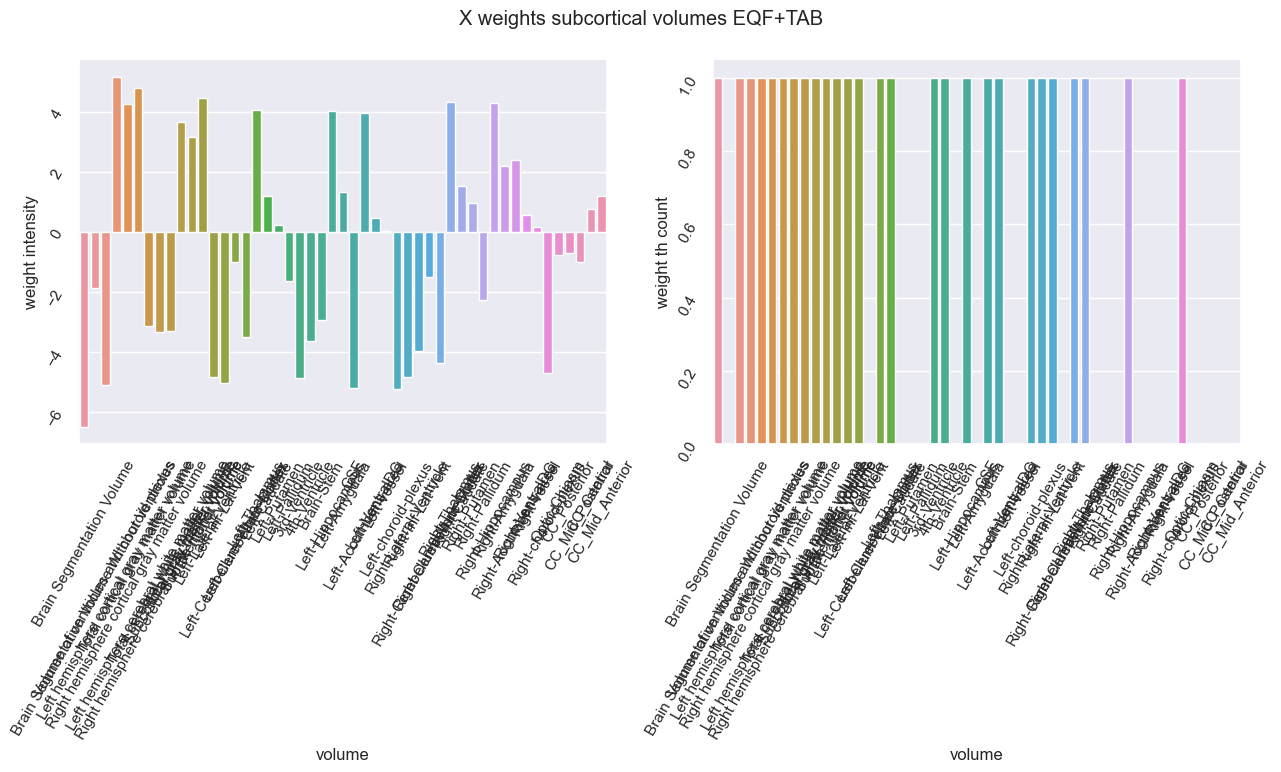

In [110]:
sch_x_v_weights_PSI = pls_PSI.bootres.x_weights_normed[:49,0]
df_x_weights_v_PSI = pd.DataFrame(sch_x_v_weights_PSI, columns=["weight"])
df_x_weights_v_PSI['volume'] = list(PSI_data.iloc[:,:49].columns)
#df_x_weights_v_TAB['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_PSI["weight_th"] =  (abs(df_x_weights_v_PSI["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes EQF+TAB')

g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_PSI)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_PSI)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)


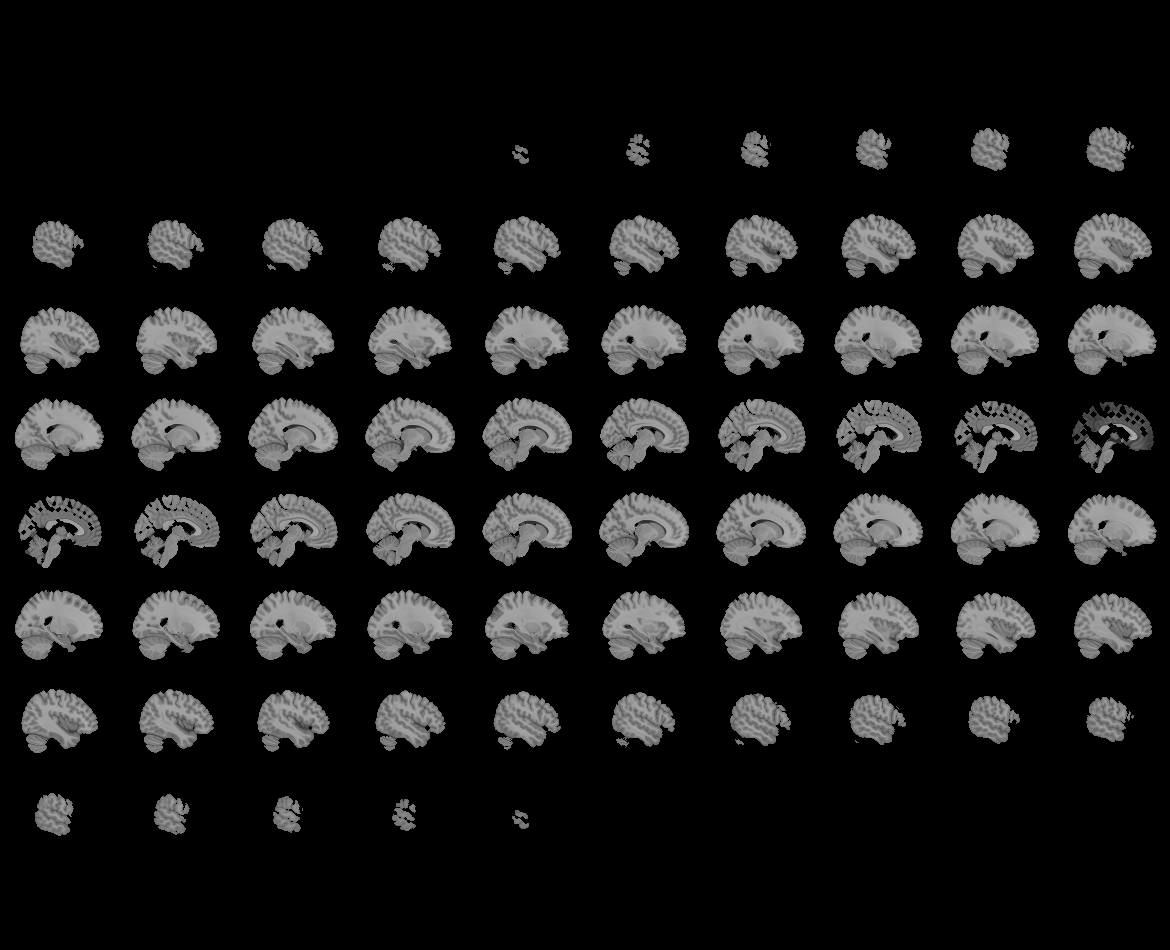
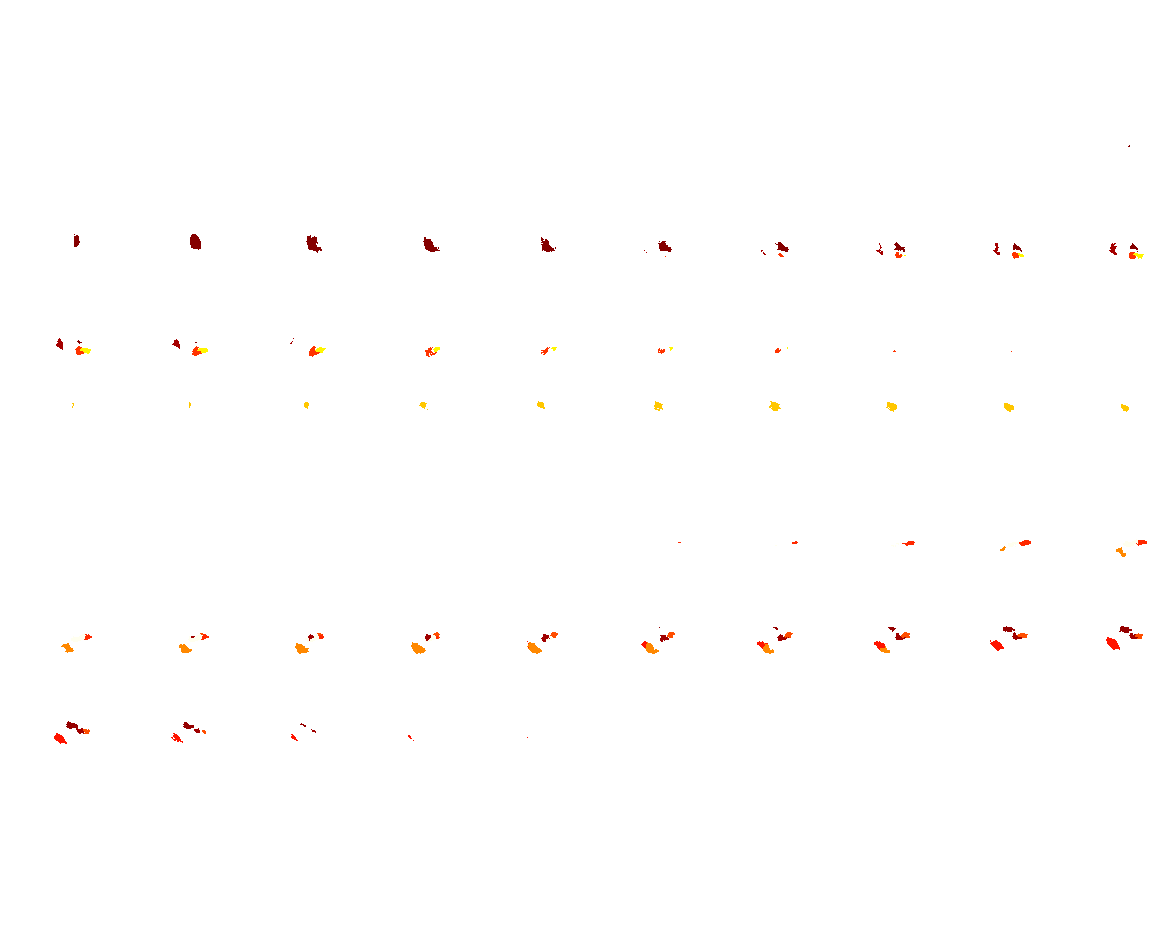

In [111]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii' 
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th=3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_PSI[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights EQF+TAB', symmetric_cmap=False)

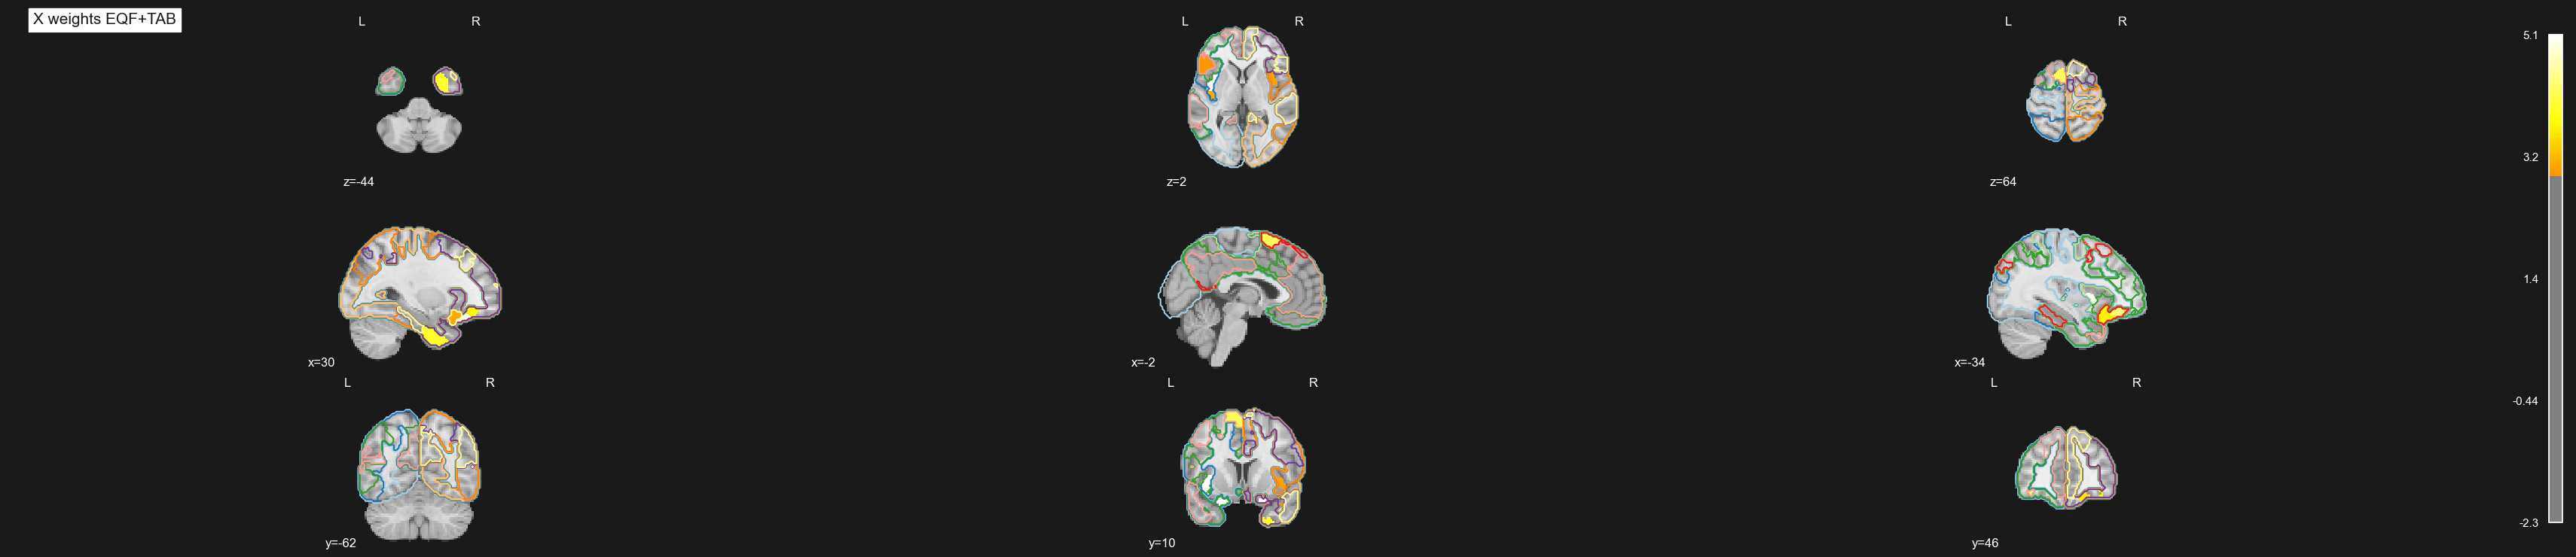

In [112]:
# Ploting stat map
#(barrido axial), que se puedan superponer los bordes de las redes (plot contours)
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
display = plotting.plot_stat_map(values_brain_weight_vol, display_mode='mosaic', cut_coords=(3,3,3), title='X weights EQF+TAB', 
                       threshold=th, dim = 0, symmetric_cbar=False, black_bg=True,
                       colorbar=True)
display.add_contours(schaefer_image, cmap='Paired')


/opt/miniconda3/lib/python3.9/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)
/opt/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


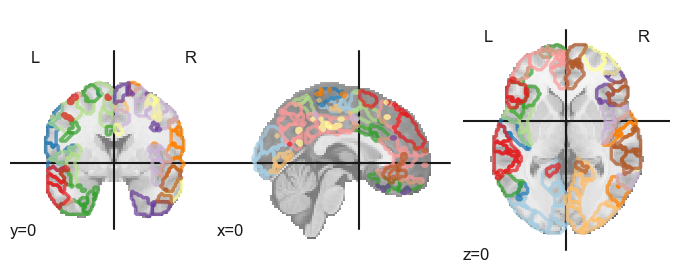

In [113]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
plotting.plot_roi(schaefer_image, view_type='contours', title="", cmap='Paired')
plotting.show()